# The PIPELINE is in three parts:

## Train a classifier to recognize vehicles

a) Cell __ STEP 1 __  check the samples for cars and not cars, display one image from each set 
b) cell __ STEP 2 __  we extract the color  and the HOG features
        In this step we use the Histogram of Oriented Gradients for feature extraction and normalized

        # Read in each one by one
        # apply color conversion if other than 'RGB'
        # Apply bin_spatial() to get spatial color features
        # Apply color_hist() to get color histogram features
        # Append the new feature vector to the features list
        # Return list of feature vectors

    #Parameters to extract the features
    colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 0

c) Cell __ STEP 3 __  Normalize the samples
    Divide the smplesinto test and training sets
    Apply the classifier SVM
    Try out the recognition on a single image
    Save the model and the scaler (generate 2 files)

## Roll the classification on a sliding-window  

Recognize vehicles on a video

## Reject false positives and apply on a video stream

Reject false positives using heat maps
Overlay lane detection from previous project4


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2
import pickle
from random import randint

import time
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import scipy as sc
from library_classifier import *




('vector cars is:', 8792)
('non cars is:', 8968)
('random cars_sample cars is:', 5433)
('random nonnotcars_samplecars is:', 1707)
('Your function returned a count of', 8792, ' cars and', 8968, ' non-cars')
('of size: ', (64, 64, 3), ' and data type:', dtype('float32'))


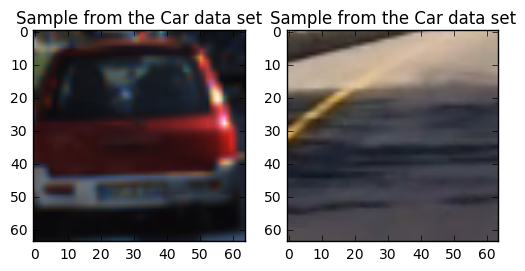

In [17]:
# __ STEP 1  __ Extracting the path of the two data sets: vehicles and non-vechicles
path_images_cars = glob.glob('vehicles/*/*.png')
cars = []
notcars = []
for image in path_images_cars:
    cars.append(image)

path_images_notcars = glob.glob('non-vehicles/*/*.png')
for image in path_images_notcars:
    notcars.append(image)

# Rendering one image from each set for testing    
cars_sample=randint(0,len(cars))
notcars_sample=randint(0, len(notcars))
print ("vector cars is:", len(cars))
print ("non cars is:", len(notcars))
print ("random cars_sample cars is:", cars_sample)
print ("random nonnotcars_samplecars is:", notcars_sample)



# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
img = plt.imread(cars[cars_sample])
plt.imshow(img)
plt.title('Sample from the Car data set')
plt.subplot(122)
img = plt.imread(notcars[notcars_sample])
plt.imshow(img)
plt.title('Sample from the Car data set')
plt.show()
      

    

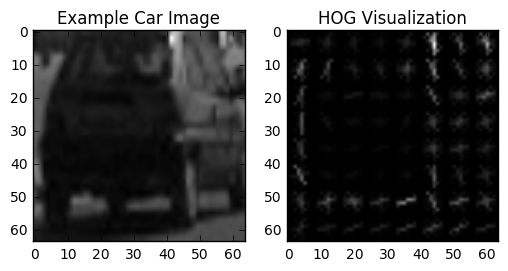

In [18]:
# Extractingthe features HOG
# Cell __ STEP 2  __


#Parameters for the features extraction 

color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 680] # Min and max in y to search in slide_window()



# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(gray, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.show()

(56.33, 'Seconds to extract HOG features...')
('cars is length:', 8792)
('notcars is length', 8968)
('number of features', 8792)
(' number of features', 8968)


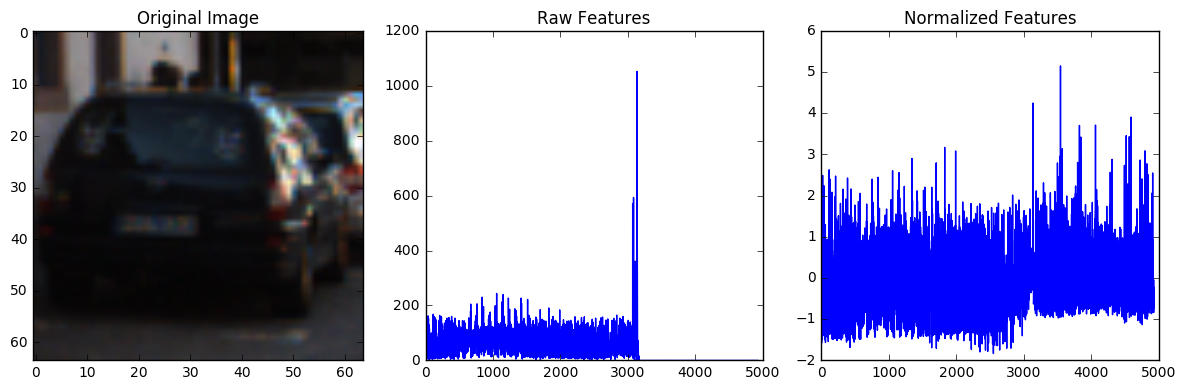

((4932,), (4932,), (4932,))


In [19]:
# Extracting Colro features

t=time.time() # counting time start
car_features = extract_features(cars, color_space=color_space, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, color_space=color_space, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time() # counting time stop
print(round(t2-t, 2), 'Seconds to extract HOG features...')


print ("cars is length:",len(cars))
print ("notcars is length",len(notcars))
print ("number of features", len(car_features))
print (" number of features",len(notcar_features))

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    
    plt.title('Original Image')
    plt.subplot(132)
   
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
   
    plt.title('Normalized Features')
    #plt.show()
    fig.tight_layout()
    plt.show()
else: 
    print('Your function only returns empty feature vectors...')

print(notcar_features[2].shape, notcar_features[0].shape, notcar_features[1].shape)

In [5]:
# Cell __ STEP 3 __
# Training a SVC estimator 

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('TRAIN Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))
print('TEST Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 20
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

# save the model to disk
filename = 'model_color_hog.sav'
pickle.dump(svc, open(filename, 'wb'))
filename = 'save_scaler.sav'
pickle.dump(X_scaler, open(filename, 'wb'))



('Using:', 9, 'orientations', 8, 'pixels per cell and', 2, 'cells per block')
('Feature vector length:', 4932)
(19.01, 'Seconds to train SVC...')
('TRAIN Accuracy of SVC = ', 1.0)
('TEST Accuracy of SVC = ', 0.9755)
('My SVC predicts: ', array([ 1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,
        0.,  1.,  0.,  1.,  0.,  1.,  0.]))
('For these', 20, 'labels: ', array([ 1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,
        0.,  1.,  0.,  1.,  0.,  1.,  0.]))
(0.01309, 'Seconds to predict', 20, 'labels with SVC')


In [ ]:
# Cell __STEP 4__ creating windows where to recognize patters and display them on a single image
# possible_windows is the list of overlapping windows where classifier will work on
# example is dispayed on result_image

from library_classifier import *

image_test1 = mpimg.imread('test1.jpg')
image_test5 = mpimg.imread('test5.jpg')
test_images = []
test_images.append(np.copy(image_test1))
test_images.append(np.copy(image_test5))

#defining regions of interest and size of boxes to look for recognitions
scales = [(40,40), (60,60), (90,90), (120,120), (170,170)]
overlaps = [0.5, 0.5, 0.5, 0.5, 0.5]
y_stops = [500, 550, 600, 650, None]
x_start_stops = [[400,850], [360,890], [320,930], [None, None], [None, None]]
colors = [(0,255,0), (255,0,0), (128,128,0), (0,128,128), (128,0,128)]

result_image = []
for image in test_images:
    possible_windows = np.copy(image)
    for scale, overlap, color, y_stop, x_start_stop in zip(scales, overlaps, colors, y_stops, x_start_stops):

        windows = slide_window(possible_windows, x_start_stop=x_start_stop, y_start_stop=[380,y_stop],
                                   xy_window=scale, xy_overlap=(overlap, overlap))

        possible_windows = draw_boxes(possible_windows, windows, color=color, thick=6) 

    result_image.append((np.copy(possible_windows)))

# Plot the test images
for i in range(len(result_image)):
    imgplot = plt.imshow(result_image[i])
    plt.show()
      


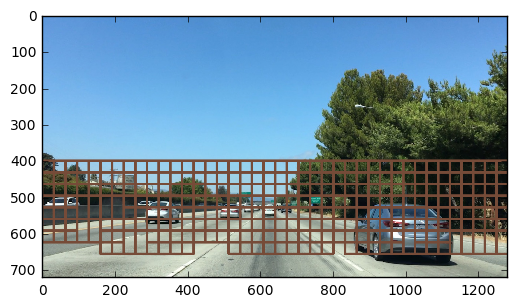

In [7]:
# In this STEP we use the classifier that we previously training and the list of windows we defined
# we apply the classifier on a single image


from library_classifier import *

# load SVM model
svc = pickle.load(open('model_color_hog.sav', 'rb'))

# load scaler
X_scaler = pickle.load(open('save_scaler.sav', 'rb'))

color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 2 # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 680] # Min and max in y to search in slide_window()


image = mpimg.imread('bbox-example-image.jpg')
draw_image = np.copy(image)

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.50, 0.50))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(118, 75, 56), thick=6)                    

plt.imshow(window_img)
plt.show()


In [17]:
ystart = 400
ystop = 656
scale = 1.5
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
    
out_img = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)
plt.show()

ValueError: operands could not be broadcast together with shapes (1,4356) (4932,) (1,4356) 

In [20]:
def pipeline(file, output_dir, save_inter, svc, scaler, filepath, debugging_tracking):

    from scipy.ndimage.measurements import label
    import os

    if filepath == True:
        print("processing : {}".format(file))
        img = cv2.imread(file)
        image_name = os.path.split(file)[-1]
    else :
        img = file
        image_name = 'video'


    # load scaler
    #X_scaler = pickle.load(open('save_scaler.sav', 'rb'))

    # ################## SETTINGS PIPELINE ################################
    scales = [(64, 64), (96, 96), (128, 128)]
    overlaps = [0.50, 0.50, 0.50]
    y_start_stops = [[400, 500], [400, 500], [400, 600]]
    x_start_stops = [[None, None], [None, None], [None, None]]
    colors = [(255, 0, 0), (128, 128, 0), (0, 128, 128)]
    # #####################################################################

    # ################## SETTINGS CLASSIFIER ##############################
    color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 2 # Can be 0, 1, 2, or "ALL"
    spatial_size = (32, 32) # Spatial binning dimensions
    hist_bins = 32    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    y_start_stop = [400, 680] # Min and max in y to search in slide_window()

    # #####################################################################

    heat = np.zeros_like(img[:, :, 0]).astype(np.uint8)
    
    windowed_image = np.copy(img)
    hot_windowed_image = np.copy(img)
    

    # STEP 1 : compute the sliding windows
    for scale, overlap, color, y_start_stop, x_start_stop in zip(scales, overlaps, colors, y_start_stops, x_start_stops):
        
        windows = slide_window(img, x_start_stop=x_start_stop, y_start_stop=y_start_stop,
                               xy_window=scale, xy_overlap=(overlap, overlap))

        # STEP 2 : Apply classifier on current windows
        
        hot_windows = search_windows(img, windows, svc, scaler=X_scaler, color_space=color_space,
                                     spatial_size=spatial_size, hist_bins=hist_bins,
                                     orient=orient, pix_per_cell=pix_per_cell,
                                     cell_per_block=cell_per_block,
                                     hog_channel=hog_channel, spatial_feat=spatial_feat,
                                     hist_feat=hist_feat, hog_feat=hog_feat)
        
        
        # STEP 3 : Compute/Update HeatMap
        heat = add_heat(heat, hot_windows)
        
        # adding heatmap over frames
        if ( tracking.frame_cpt==1):
            tracking.heatmap_prev=np.copy(heat)
            
        tracking.heatmap_prev = np.dstack((heat, tracking.heatmap_prev))
        tracking.heatmap_average = np.mean(tracking.heatmap_prev, axis = 2).astype(np.uint8)
        heat = np.copy(tracking.heatmap_average)
        print ("lenght of heat prev vector",len(tracking.heatmap_prev) )
        
        print ("frame counter is", tracking.frame_cpt)
        tracking.frame_cpt += 1
            
        if (tracking.frame_cpt ==15):
            tracking.frame_cpt=0
            tracking.heatmap_average = None
            heatmap_prev = None
            print ("averaging heatmap at", tracking.frame_cpt)
           

        if save_inter:
            # Update windowed images
            hot_windowed_image = draw_boxes(hot_windowed_image, hot_windows, color=color, thick=6)
            windowed_image = draw_boxes(windowed_image, windows, color=color, thick=6)
            
    # STEP 4 : Apply Threshold on HeatMap and map values to [0, 255]
        heat = apply_threshold(heat, 2)
        heatmap = np.clip(heat, 0, 255)
        
        
            
    if save_inter:
        cv2.imwrite(os.path.join(output_dir, 'heatmap_' + image_name), heatmap)

    # STEP 5 : Determine bounding boxes and draw on images
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    if (debugging_tracking==True):
            
            #displayng original image
            #displaying heatmap
           
            imgplot = plt.imshow(img)
            plt.show()
            #displaying heatmap
            imgplot = plt.imshow(heatmap, cmap='hot')
            plt.show()
    
    return draw_img

processing : bbox-example-image.jpg
('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


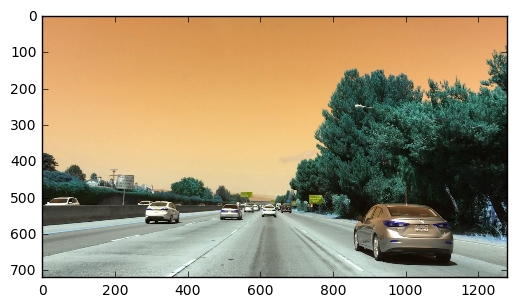

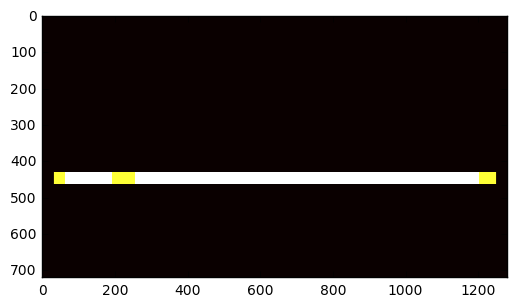

array([[[218, 151,  96],
        [218, 151,  96],
        [218, 151,  96],
        ..., 
        [217, 147,  94],
        [217, 147,  94],
        [218, 148,  95]],

       [[219, 152,  97],
        [219, 152,  97],
        [219, 152,  97],
        ..., 
        [217, 147,  94],
        [218, 148,  95],
        [218, 148,  95]],

       [[219, 152,  97],
        [220, 153,  98],
        [220, 153,  98],
        ..., 
        [217, 147,  94],
        [218, 148,  95],
        [218, 148,  95]],

       ..., 
       [[137, 149, 143],
        [117, 129, 123],
        [107, 119, 113],
        ..., 
        [144, 161, 152],
        [152, 168, 161],
        [155, 171, 164]],

       [[130, 140, 134],
        [134, 144, 138],
        [146, 156, 150],
        ..., 
        [150, 167, 158],
        [152, 168, 161],
        [149, 165, 158]],

       [[127, 137, 131],
        [134, 144, 138],
        [156, 166, 160],
        ..., 
        [149, 165, 158],
        [154, 170, 163],
        [151, 167,

In [14]:
# Trying the pipeline on 1 image
from library_classifier import *

debugging_tracking = True
tracking = tracking_car()

image_path = 'bbox-example-image.jpg'
pipeline(image_path, None, False, svc, X_scaler, True, debugging_tracking)

In [21]:
from moviepy.editor import VideoFileClip

start = time.time()

#load the models
svc = pickle.load(open('model_color_hog.sav', 'rb'))
# load scaler
X_scaler = pickle.load(open('save_scaler.sav', 'rb'))

file="project_video.mp4"

def create_image_pipeline(svc, scaler):
        def image_pipeline(file):
            return pipeline(file, None, False, svc, scaler, filepath=False, debugging_tracking=False)
        return image_pipeline

image_pipeline = create_image_pipeline(svc, X_scaler)

# load input_video
clip1 = VideoFileClip("project_video.mp4")

# apply the pipeline to the video
output_clip = clip1.fl_image(image_pipeline)

# save the new video
output_video ="result_video.mp4"
output_clip.write_videofile(output_video, audio=False)

print("\nScript took {} seconds\n\n".format(time.time() - start))


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)
[MoviePy] >>>> Building video result_video.mp4
[MoviePy] Writing video result_video.mp4



  0%|          | 0/1261 [00:00<?, ?it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



  0%|          | 1/1261 [00:00<09:16,  2.26it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



  0%|          | 2/1261 [00:00<09:22,  2.24it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



  0%|          | 3/1261 [00:01<09:37,  2.18it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



  0%|          | 4/1261 [00:01<09:11,  2.28it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



  0%|          | 5/1261 [00:02<09:07,  2.30it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



  0%|          | 6/1261 [00:02<09:25,  2.22it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



  1%|          | 7/1261 [00:03<09:27,  2.21it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



  1%|          | 8/1261 [00:03<09:26,  2.21it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



  1%|          | 9/1261 [00:03<08:59,  2.32it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



  1%|          | 10/1261 [00:04<08:51,  2.35it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



  1%|          | 11/1261 [00:04<08:49,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



  1%|          | 12/1261 [00:05<08:49,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



  1%|          | 13/1261 [00:05<08:59,  2.31it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



  1%|          | 14/1261 [00:06<08:37,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



  1%|          | 15/1261 [00:06<08:33,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



  1%|▏         | 16/1261 [00:06<08:33,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



  1%|▏         | 17/1261 [00:07<08:36,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



  1%|▏         | 18/1261 [00:07<08:43,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



  2%|▏         | 19/1261 [00:08<08:25,  2.46it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



  2%|▏         | 20/1261 [00:08<08:20,  2.48it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



  2%|▏         | 21/1261 [00:08<08:21,  2.47it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



  2%|▏         | 22/1261 [00:09<08:25,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



  2%|▏         | 23/1261 [00:09<08:33,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



  2%|▏         | 24/1261 [00:10<08:17,  2.49it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



  2%|▏         | 25/1261 [00:10<08:14,  2.50it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



  2%|▏         | 26/1261 [00:10<08:19,  2.47it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



  2%|▏         | 27/1261 [00:11<08:25,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



  2%|▏         | 28/1261 [00:11<08:37,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



  2%|▏         | 29/1261 [00:12<08:19,  2.47it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



  2%|▏         | 30/1261 [00:12<08:21,  2.46it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



  2%|▏         | 31/1261 [00:13<08:24,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



  3%|▎         | 32/1261 [00:13<08:26,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



  3%|▎         | 33/1261 [00:13<08:34,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



  3%|▎         | 34/1261 [00:14<08:18,  2.46it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



  3%|▎         | 35/1261 [00:14<08:17,  2.46it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



  3%|▎         | 36/1261 [00:15<08:17,  2.46it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



  3%|▎         | 37/1261 [00:15<08:19,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



  3%|▎         | 38/1261 [00:15<08:27,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



  3%|▎         | 39/1261 [00:16<08:10,  2.49it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



  3%|▎         | 40/1261 [00:16<08:09,  2.49it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



  3%|▎         | 41/1261 [00:17<08:07,  2.50it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



  3%|▎         | 42/1261 [00:17<08:10,  2.48it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



  3%|▎         | 43/1261 [00:17<08:23,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



  3%|▎         | 44/1261 [00:18<08:07,  2.50it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



  4%|▎         | 45/1261 [00:18<08:06,  2.50it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



  4%|▎         | 46/1261 [00:19<08:07,  2.49it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



  4%|▎         | 47/1261 [00:19<08:13,  2.46it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



  4%|▍         | 48/1261 [00:19<08:24,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



  4%|▍         | 49/1261 [00:20<08:10,  2.47it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



  4%|▍         | 50/1261 [00:20<08:09,  2.48it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



  4%|▍         | 51/1261 [00:21<08:10,  2.47it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



  4%|▍         | 52/1261 [00:21<08:22,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



  4%|▍         | 53/1261 [00:22<08:29,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



  4%|▍         | 54/1261 [00:22<08:12,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



  4%|▍         | 55/1261 [00:22<08:11,  2.46it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



  4%|▍         | 56/1261 [00:23<08:12,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



  5%|▍         | 57/1261 [00:23<08:18,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



  5%|▍         | 58/1261 [00:24<08:24,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



  5%|▍         | 59/1261 [00:24<08:07,  2.47it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



  5%|▍         | 60/1261 [00:24<08:06,  2.47it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



  5%|▍         | 61/1261 [00:25<08:05,  2.47it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



  5%|▍         | 62/1261 [00:25<08:08,  2.46it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



  5%|▍         | 63/1261 [00:26<08:18,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



  5%|▌         | 64/1261 [00:26<07:59,  2.49it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



  5%|▌         | 65/1261 [00:26<07:58,  2.50it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



  5%|▌         | 66/1261 [00:27<07:57,  2.50it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



  5%|▌         | 67/1261 [00:27<08:02,  2.47it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



  5%|▌         | 68/1261 [00:28<08:11,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



  5%|▌         | 69/1261 [00:28<08:00,  2.48it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



  6%|▌         | 70/1261 [00:28<08:00,  2.48it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



  6%|▌         | 71/1261 [00:29<08:02,  2.47it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



  6%|▌         | 72/1261 [00:29<08:06,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



  6%|▌         | 73/1261 [00:30<08:17,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



  6%|▌         | 74/1261 [00:30<08:01,  2.47it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



  6%|▌         | 75/1261 [00:30<08:00,  2.47it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



  6%|▌         | 76/1261 [00:31<08:02,  2.46it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



  6%|▌         | 77/1261 [00:31<08:09,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



  6%|▌         | 78/1261 [00:32<08:19,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



  6%|▋         | 79/1261 [00:32<08:02,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



  6%|▋         | 80/1261 [00:32<07:59,  2.46it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



  6%|▋         | 81/1261 [00:33<08:01,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



  7%|▋         | 82/1261 [00:33<08:06,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



  7%|▋         | 83/1261 [00:34<08:21,  2.35it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



  7%|▋         | 84/1261 [00:34<08:08,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



  7%|▋         | 85/1261 [00:35<08:05,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



  7%|▋         | 86/1261 [00:35<08:01,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



  7%|▋         | 87/1261 [00:35<08:03,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



  7%|▋         | 88/1261 [00:36<08:11,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



  7%|▋         | 89/1261 [00:36<08:01,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



  7%|▋         | 90/1261 [00:37<07:56,  2.46it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



  7%|▋         | 91/1261 [00:37<07:57,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



  7%|▋         | 92/1261 [00:37<07:59,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



  7%|▋         | 93/1261 [00:38<08:09,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



  7%|▋         | 94/1261 [00:38<07:56,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



  8%|▊         | 95/1261 [00:39<07:54,  2.46it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



  8%|▊         | 96/1261 [00:39<07:54,  2.46it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



  8%|▊         | 97/1261 [00:40<07:58,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



  8%|▊         | 98/1261 [00:40<08:13,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



  8%|▊         | 99/1261 [00:40<07:57,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



  8%|▊         | 100/1261 [00:41<07:52,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



  8%|▊         | 101/1261 [00:41<07:50,  2.47it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



  8%|▊         | 102/1261 [00:42<07:52,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



  8%|▊         | 103/1261 [00:42<08:01,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



  8%|▊         | 104/1261 [00:42<07:48,  2.47it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



  8%|▊         | 105/1261 [00:43<07:47,  2.47it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



  8%|▊         | 106/1261 [00:43<07:48,  2.47it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



  8%|▊         | 107/1261 [00:44<07:53,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



  9%|▊         | 108/1261 [00:44<08:09,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



  9%|▊         | 109/1261 [00:44<07:56,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



  9%|▊         | 110/1261 [00:45<07:52,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



  9%|▉         | 111/1261 [00:45<07:51,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



  9%|▉         | 112/1261 [00:46<07:56,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



  9%|▉         | 113/1261 [00:46<08:12,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



  9%|▉         | 114/1261 [00:47<07:57,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



  9%|▉         | 115/1261 [00:47<07:51,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



  9%|▉         | 116/1261 [00:47<07:48,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



  9%|▉         | 117/1261 [00:48<07:55,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



  9%|▉         | 118/1261 [00:48<08:08,  2.34it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



  9%|▉         | 119/1261 [00:49<07:50,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 10%|▉         | 120/1261 [00:49<07:49,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 10%|▉         | 121/1261 [00:49<07:47,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 10%|▉         | 122/1261 [00:50<07:50,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 10%|▉         | 123/1261 [00:50<08:02,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 10%|▉         | 124/1261 [00:51<07:45,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 10%|▉         | 125/1261 [00:51<07:40,  2.47it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 10%|▉         | 126/1261 [00:51<07:41,  2.46it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 10%|█         | 127/1261 [00:52<07:47,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 10%|█         | 128/1261 [00:52<07:59,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 10%|█         | 129/1261 [00:53<07:42,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 10%|█         | 130/1261 [00:53<07:38,  2.47it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 10%|█         | 131/1261 [00:54<07:37,  2.47it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 10%|█         | 132/1261 [00:54<07:40,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 11%|█         | 133/1261 [00:54<07:55,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)



 11%|█         | 134/1261 [00:55<07:57,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 11%|█         | 135/1261 [00:55<08:00,  2.34it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 11%|█         | 136/1261 [00:56<08:02,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 11%|█         | 137/1261 [00:56<08:11,  2.29it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 11%|█         | 138/1261 [00:57<08:17,  2.26it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 11%|█         | 139/1261 [00:57<07:57,  2.35it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 11%|█         | 140/1261 [00:57<07:48,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 11%|█         | 141/1261 [00:58<07:50,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 11%|█▏        | 142/1261 [00:58<07:54,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 11%|█▏        | 143/1261 [00:59<08:01,  2.32it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 11%|█▏        | 144/1261 [00:59<07:45,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 11%|█▏        | 145/1261 [00:59<07:45,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 12%|█▏        | 146/1261 [01:00<07:47,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 12%|█▏        | 147/1261 [01:00<07:54,  2.35it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 12%|█▏        | 148/1261 [01:01<08:04,  2.30it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)



 12%|█▏        | 149/1261 [01:01<07:45,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 12%|█▏        | 150/1261 [01:02<07:42,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 12%|█▏        | 151/1261 [01:02<07:41,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 12%|█▏        | 152/1261 [01:02<07:46,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 12%|█▏        | 153/1261 [01:03<07:57,  2.32it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 12%|█▏        | 154/1261 [01:03<07:38,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 12%|█▏        | 155/1261 [01:04<07:38,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 12%|█▏        | 156/1261 [01:04<07:41,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 12%|█▏        | 157/1261 [01:05<07:45,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 13%|█▎        | 158/1261 [01:05<07:55,  2.32it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 13%|█▎        | 159/1261 [01:05<07:40,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 13%|█▎        | 160/1261 [01:06<07:37,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 13%|█▎        | 161/1261 [01:06<07:38,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 13%|█▎        | 162/1261 [01:07<07:42,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 13%|█▎        | 163/1261 [01:07<07:49,  2.34it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 13%|█▎        | 164/1261 [01:07<07:30,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 13%|█▎        | 165/1261 [01:08<07:29,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 13%|█▎        | 166/1261 [01:08<07:31,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 13%|█▎        | 167/1261 [01:09<07:35,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 13%|█▎        | 168/1261 [01:09<07:47,  2.34it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 13%|█▎        | 169/1261 [01:10<07:30,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 13%|█▎        | 170/1261 [01:10<07:25,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 14%|█▎        | 171/1261 [01:10<07:26,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 14%|█▎        | 172/1261 [01:11<07:29,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 14%|█▎        | 173/1261 [01:11<07:40,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 14%|█▍        | 174/1261 [01:12<07:22,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 14%|█▍        | 175/1261 [01:12<07:20,  2.47it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 14%|█▍        | 176/1261 [01:12<07:21,  2.46it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 14%|█▍        | 177/1261 [01:13<07:27,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 14%|█▍        | 178/1261 [01:13<07:38,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 14%|█▍        | 179/1261 [01:14<07:23,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 14%|█▍        | 180/1261 [01:14<07:20,  2.46it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 14%|█▍        | 181/1261 [01:14<07:20,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 14%|█▍        | 182/1261 [01:15<07:24,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 15%|█▍        | 183/1261 [01:15<07:31,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 15%|█▍        | 184/1261 [01:16<07:21,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 15%|█▍        | 185/1261 [01:16<07:23,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 15%|█▍        | 186/1261 [01:17<07:23,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 15%|█▍        | 187/1261 [01:17<07:25,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 15%|█▍        | 188/1261 [01:17<07:33,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 15%|█▍        | 189/1261 [01:18<07:19,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 15%|█▌        | 190/1261 [01:18<07:17,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 15%|█▌        | 191/1261 [01:19<07:17,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 15%|█▌        | 192/1261 [01:19<07:18,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 15%|█▌        | 193/1261 [01:19<07:26,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 15%|█▌        | 194/1261 [01:20<07:11,  2.47it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 15%|█▌        | 195/1261 [01:20<07:11,  2.47it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 16%|█▌        | 196/1261 [01:21<07:11,  2.47it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 16%|█▌        | 197/1261 [01:21<07:16,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 16%|█▌        | 198/1261 [01:21<07:24,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 16%|█▌        | 199/1261 [01:22<07:11,  2.46it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 16%|█▌        | 200/1261 [01:22<07:11,  2.46it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 16%|█▌        | 201/1261 [01:23<07:11,  2.46it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 16%|█▌        | 202/1261 [01:23<07:13,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 16%|█▌        | 203/1261 [01:24<07:20,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 16%|█▌        | 204/1261 [01:24<07:09,  2.46it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 16%|█▋        | 205/1261 [01:24<07:10,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 16%|█▋        | 206/1261 [01:25<07:10,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 16%|█▋        | 207/1261 [01:25<07:14,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 16%|█▋        | 208/1261 [01:26<07:25,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 17%|█▋        | 209/1261 [01:26<07:12,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 17%|█▋        | 210/1261 [01:26<07:16,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 17%|█▋        | 211/1261 [01:27<07:12,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 17%|█▋        | 212/1261 [01:27<07:15,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 17%|█▋        | 213/1261 [01:28<07:22,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 17%|█▋        | 214/1261 [01:28<07:08,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 17%|█▋        | 215/1261 [01:28<07:05,  2.46it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 17%|█▋        | 216/1261 [01:29<07:04,  2.46it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 17%|█▋        | 217/1261 [01:29<07:08,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 17%|█▋        | 218/1261 [01:30<07:21,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 17%|█▋        | 219/1261 [01:30<07:10,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 17%|█▋        | 220/1261 [01:31<07:09,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 18%|█▊        | 221/1261 [01:31<07:10,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 18%|█▊        | 222/1261 [01:31<07:11,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 18%|█▊        | 223/1261 [01:32<07:20,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 18%|█▊        | 224/1261 [01:32<07:09,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 18%|█▊        | 225/1261 [01:33<07:08,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 18%|█▊        | 226/1261 [01:33<07:08,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 18%|█▊        | 227/1261 [01:33<07:11,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 18%|█▊        | 228/1261 [01:34<07:22,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 18%|█▊        | 229/1261 [01:34<07:12,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 18%|█▊        | 230/1261 [01:35<07:07,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 18%|█▊        | 231/1261 [01:35<07:05,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 18%|█▊        | 232/1261 [01:36<07:09,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 18%|█▊        | 233/1261 [01:36<07:19,  2.34it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 19%|█▊        | 234/1261 [01:36<07:07,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 19%|█▊        | 235/1261 [01:37<07:08,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 19%|█▊        | 236/1261 [01:37<07:09,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 19%|█▉        | 237/1261 [01:38<07:12,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 19%|█▉        | 238/1261 [01:38<07:19,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 19%|█▉        | 239/1261 [01:38<07:04,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 19%|█▉        | 240/1261 [01:39<06:59,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 19%|█▉        | 241/1261 [01:39<06:57,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 19%|█▉        | 242/1261 [01:40<06:58,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 19%|█▉        | 243/1261 [01:40<07:09,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 19%|█▉        | 244/1261 [01:41<06:56,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 19%|█▉        | 245/1261 [01:41<06:54,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 20%|█▉        | 246/1261 [01:41<06:54,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 20%|█▉        | 247/1261 [01:42<07:00,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 20%|█▉        | 248/1261 [01:42<07:11,  2.35it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 20%|█▉        | 249/1261 [01:43<06:58,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 20%|█▉        | 250/1261 [01:43<06:52,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 20%|█▉        | 251/1261 [01:43<06:51,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 20%|█▉        | 252/1261 [01:44<06:54,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 20%|██        | 253/1261 [01:44<07:05,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 20%|██        | 254/1261 [01:45<06:51,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 20%|██        | 255/1261 [01:45<06:49,  2.46it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 20%|██        | 256/1261 [01:45<06:49,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 20%|██        | 257/1261 [01:46<07:00,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 20%|██        | 258/1261 [01:46<07:13,  2.32it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 21%|██        | 259/1261 [01:47<06:56,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 21%|██        | 260/1261 [01:47<06:54,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 21%|██        | 261/1261 [01:48<06:54,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 21%|██        | 262/1261 [01:48<06:58,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 21%|██        | 263/1261 [01:48<07:06,  2.34it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 21%|██        | 264/1261 [01:49<06:52,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 21%|██        | 265/1261 [01:49<06:47,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 21%|██        | 266/1261 [01:50<06:48,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 21%|██        | 267/1261 [01:50<06:52,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 21%|██▏       | 268/1261 [01:51<07:02,  2.35it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 21%|██▏       | 269/1261 [01:51<06:52,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 21%|██▏       | 270/1261 [01:51<06:47,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 21%|██▏       | 271/1261 [01:52<06:49,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 22%|██▏       | 272/1261 [01:52<06:55,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 22%|██▏       | 273/1261 [01:53<07:04,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 22%|██▏       | 274/1261 [01:53<06:54,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 22%|██▏       | 275/1261 [01:53<06:53,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 22%|██▏       | 276/1261 [01:54<07:01,  2.34it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 22%|██▏       | 277/1261 [01:54<07:24,  2.21it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 22%|██▏       | 278/1261 [01:55<07:36,  2.15it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)



 22%|██▏       | 279/1261 [01:55<07:11,  2.27it/s]

('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 22%|██▏       | 280/1261 [01:56<07:03,  2.32it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 22%|██▏       | 281/1261 [01:56<06:55,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 22%|██▏       | 282/1261 [01:57<06:58,  2.34it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 22%|██▏       | 283/1261 [01:57<07:06,  2.29it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 23%|██▎       | 284/1261 [01:57<06:49,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 23%|██▎       | 285/1261 [01:58<06:54,  2.35it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 23%|██▎       | 286/1261 [01:58<06:54,  2.35it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 23%|██▎       | 287/1261 [01:59<06:52,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 23%|██▎       | 288/1261 [01:59<06:56,  2.34it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 23%|██▎       | 289/1261 [01:59<06:40,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 23%|██▎       | 290/1261 [02:00<06:36,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 23%|██▎       | 291/1261 [02:00<06:37,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 23%|██▎       | 292/1261 [02:01<06:41,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 23%|██▎       | 293/1261 [02:01<06:47,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 23%|██▎       | 294/1261 [02:02<06:34,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 23%|██▎       | 295/1261 [02:02<06:31,  2.47it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 23%|██▎       | 296/1261 [02:02<06:32,  2.46it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 24%|██▎       | 297/1261 [02:03<06:36,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 24%|██▎       | 298/1261 [02:03<06:45,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 24%|██▎       | 299/1261 [02:04<06:31,  2.46it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 24%|██▍       | 300/1261 [02:04<06:32,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 24%|██▍       | 301/1261 [02:04<06:36,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 24%|██▍       | 302/1261 [02:05<06:45,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 24%|██▍       | 303/1261 [02:05<06:50,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 24%|██▍       | 304/1261 [02:06<06:37,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 24%|██▍       | 305/1261 [02:06<06:40,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 24%|██▍       | 306/1261 [02:07<06:42,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 24%|██▍       | 307/1261 [02:07<06:47,  2.34it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 24%|██▍       | 308/1261 [02:07<06:53,  2.30it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 25%|██▍       | 309/1261 [02:08<06:44,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 25%|██▍       | 310/1261 [02:08<06:45,  2.35it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 25%|██▍       | 311/1261 [02:09<06:57,  2.28it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 25%|██▍       | 312/1261 [02:09<06:55,  2.28it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 25%|██▍       | 313/1261 [02:10<06:55,  2.28it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 25%|██▍       | 314/1261 [02:10<06:39,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 25%|██▍       | 315/1261 [02:10<06:35,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 25%|██▌       | 316/1261 [02:11<06:33,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 25%|██▌       | 317/1261 [02:11<06:32,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 25%|██▌       | 318/1261 [02:12<06:43,  2.34it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 25%|██▌       | 319/1261 [02:12<06:31,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 25%|██▌       | 320/1261 [02:12<06:29,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 25%|██▌       | 321/1261 [02:13<06:32,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 26%|██▌       | 322/1261 [02:13<06:38,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 26%|██▌       | 323/1261 [02:14<06:48,  2.30it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 26%|██▌       | 324/1261 [02:14<06:31,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 26%|██▌       | 325/1261 [02:15<06:27,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 26%|██▌       | 326/1261 [02:15<06:26,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 26%|██▌       | 327/1261 [02:15<06:28,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 26%|██▌       | 328/1261 [02:16<06:39,  2.34it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 26%|██▌       | 329/1261 [02:16<06:36,  2.35it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 26%|██▌       | 330/1261 [02:17<06:34,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 26%|██▌       | 331/1261 [02:17<06:39,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 26%|██▋       | 332/1261 [02:18<06:51,  2.26it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 26%|██▋       | 333/1261 [02:18<07:10,  2.16it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 26%|██▋       | 334/1261 [02:19<06:57,  2.22it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 27%|██▋       | 335/1261 [02:19<06:47,  2.27it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 27%|██▋       | 336/1261 [02:19<06:44,  2.29it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 27%|██▋       | 337/1261 [02:20<06:41,  2.30it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 27%|██▋       | 338/1261 [02:20<06:52,  2.24it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 27%|██▋       | 339/1261 [02:21<06:34,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 27%|██▋       | 340/1261 [02:21<06:29,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 27%|██▋       | 341/1261 [02:22<06:24,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 27%|██▋       | 342/1261 [02:22<06:27,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 27%|██▋       | 343/1261 [02:22<06:35,  2.32it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 27%|██▋       | 344/1261 [02:23<06:23,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 27%|██▋       | 345/1261 [02:23<06:18,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 27%|██▋       | 346/1261 [02:24<06:16,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 28%|██▊       | 347/1261 [02:24<06:20,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 28%|██▊       | 348/1261 [02:24<06:28,  2.35it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 28%|██▊       | 349/1261 [02:25<06:19,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 28%|██▊       | 350/1261 [02:25<06:18,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 28%|██▊       | 351/1261 [02:26<06:17,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 28%|██▊       | 352/1261 [02:26<06:22,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 28%|██▊       | 353/1261 [02:27<06:30,  2.32it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 28%|██▊       | 354/1261 [02:27<06:21,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 28%|██▊       | 355/1261 [02:27<06:15,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 28%|██▊       | 356/1261 [02:28<06:15,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 28%|██▊       | 357/1261 [02:28<06:19,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 28%|██▊       | 358/1261 [02:29<06:27,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 28%|██▊       | 359/1261 [02:29<06:14,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 29%|██▊       | 360/1261 [02:29<06:12,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 29%|██▊       | 361/1261 [02:30<06:17,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 29%|██▊       | 362/1261 [02:30<06:31,  2.30it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 29%|██▉       | 363/1261 [02:31<06:37,  2.26it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 29%|██▉       | 364/1261 [02:31<06:26,  2.32it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 29%|██▉       | 365/1261 [02:32<06:18,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 29%|██▉       | 366/1261 [02:32<06:22,  2.34it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 29%|██▉       | 367/1261 [02:33<06:29,  2.30it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 29%|██▉       | 368/1261 [02:33<06:36,  2.25it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 29%|██▉       | 369/1261 [02:33<06:23,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 29%|██▉       | 370/1261 [02:34<06:21,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 29%|██▉       | 371/1261 [02:34<06:22,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 30%|██▉       | 372/1261 [02:35<06:27,  2.29it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 30%|██▉       | 373/1261 [02:35<06:34,  2.25it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 30%|██▉       | 374/1261 [02:36<06:22,  2.32it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 30%|██▉       | 375/1261 [02:36<06:21,  2.32it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 30%|██▉       | 376/1261 [02:36<06:24,  2.30it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 30%|██▉       | 377/1261 [02:37<06:24,  2.30it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 30%|██▉       | 378/1261 [02:37<06:28,  2.27it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 30%|███       | 379/1261 [02:38<06:17,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 30%|███       | 380/1261 [02:38<06:15,  2.35it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 30%|███       | 381/1261 [02:39<06:12,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 30%|███       | 382/1261 [02:39<06:12,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 30%|███       | 383/1261 [02:39<06:20,  2.31it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 30%|███       | 384/1261 [02:40<06:10,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 31%|███       | 385/1261 [02:40<06:12,  2.35it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 31%|███       | 386/1261 [02:41<06:15,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 31%|███       | 387/1261 [02:41<06:16,  2.32it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 31%|███       | 388/1261 [02:42<06:20,  2.30it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 31%|███       | 389/1261 [02:42<06:07,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 31%|███       | 390/1261 [02:42<06:03,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 31%|███       | 391/1261 [02:43<06:03,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 31%|███       | 392/1261 [02:43<06:04,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 31%|███       | 393/1261 [02:44<06:11,  2.34it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 31%|███       | 394/1261 [02:44<05:59,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 31%|███▏      | 395/1261 [02:44<05:57,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 31%|███▏      | 396/1261 [02:45<05:58,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 31%|███▏      | 397/1261 [02:45<06:01,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 32%|███▏      | 398/1261 [02:46<06:07,  2.35it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 32%|███▏      | 399/1261 [02:46<05:57,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 32%|███▏      | 400/1261 [02:47<05:55,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 32%|███▏      | 401/1261 [02:47<05:57,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 32%|███▏      | 402/1261 [02:47<05:58,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 32%|███▏      | 403/1261 [02:48<06:06,  2.34it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 32%|███▏      | 404/1261 [02:48<05:57,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 32%|███▏      | 405/1261 [02:49<05:54,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 32%|███▏      | 406/1261 [02:49<05:53,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 32%|███▏      | 407/1261 [02:50<05:56,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 32%|███▏      | 408/1261 [02:50<06:06,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 32%|███▏      | 409/1261 [02:50<05:56,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 33%|███▎      | 410/1261 [02:51<05:56,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 33%|███▎      | 411/1261 [02:51<05:57,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 33%|███▎      | 412/1261 [02:52<05:58,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 33%|███▎      | 413/1261 [02:52<06:06,  2.31it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 33%|███▎      | 414/1261 [02:52<06:01,  2.34it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 33%|███▎      | 415/1261 [02:53<06:01,  2.34it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 33%|███▎      | 416/1261 [02:53<05:56,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 33%|███▎      | 417/1261 [02:54<05:57,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 33%|███▎      | 418/1261 [02:54<06:05,  2.31it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)



 33%|███▎      | 419/1261 [02:55<05:52,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 33%|███▎      | 420/1261 [02:55<05:47,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 33%|███▎      | 421/1261 [02:55<05:45,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 33%|███▎      | 422/1261 [02:56<05:46,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 34%|███▎      | 423/1261 [02:56<05:55,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 34%|███▎      | 424/1261 [02:57<05:43,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 34%|███▎      | 425/1261 [02:57<05:42,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 34%|███▍      | 426/1261 [02:57<05:42,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 34%|███▍      | 427/1261 [02:58<05:52,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 34%|███▍      | 428/1261 [02:58<05:59,  2.32it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 34%|███▍      | 429/1261 [02:59<05:48,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 34%|███▍      | 430/1261 [02:59<05:43,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 34%|███▍      | 431/1261 [03:00<05:44,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 34%|███▍      | 432/1261 [03:00<05:54,  2.34it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 34%|███▍      | 433/1261 [03:00<05:59,  2.30it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 34%|███▍      | 434/1261 [03:01<05:45,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 34%|███▍      | 435/1261 [03:01<05:43,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 35%|███▍      | 436/1261 [03:02<05:44,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 35%|███▍      | 437/1261 [03:02<05:46,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 35%|███▍      | 438/1261 [03:03<05:52,  2.34it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 35%|███▍      | 439/1261 [03:03<05:42,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 35%|███▍      | 440/1261 [03:03<05:40,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 35%|███▍      | 441/1261 [03:04<05:40,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 35%|███▌      | 442/1261 [03:04<05:44,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 35%|███▌      | 443/1261 [03:05<05:52,  2.32it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)


('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 35%|███▌      | 444/1261 [03:05<05:38,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 35%|███▌      | 445/1261 [03:05<05:33,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 35%|███▌      | 446/1261 [03:06<05:35,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 35%|███▌      | 447/1261 [03:06<05:43,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 36%|███▌      | 448/1261 [03:07<05:47,  2.34it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 36%|███▌      | 449/1261 [03:07<05:35,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 36%|███▌      | 450/1261 [03:08<05:33,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 36%|███▌      | 451/1261 [03:08<05:36,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 36%|███▌      | 452/1261 [03:08<05:41,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 36%|███▌      | 453/1261 [03:09<05:49,  2.31it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 36%|███▌      | 454/1261 [03:09<05:36,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 36%|███▌      | 455/1261 [03:10<05:34,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 36%|███▌      | 456/1261 [03:10<05:36,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 36%|███▌      | 457/1261 [03:11<05:39,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 36%|███▋      | 458/1261 [03:11<05:44,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 36%|███▋      | 459/1261 [03:11<05:31,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 36%|███▋      | 460/1261 [03:12<05:30,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 37%|███▋      | 461/1261 [03:12<05:33,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 37%|███▋      | 462/1261 [03:13<05:36,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 37%|███▋      | 463/1261 [03:13<05:41,  2.34it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 37%|███▋      | 464/1261 [03:13<05:28,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 37%|███▋      | 465/1261 [03:14<05:28,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 37%|███▋      | 466/1261 [03:14<05:30,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 37%|███▋      | 467/1261 [03:15<05:33,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 37%|███▋      | 468/1261 [03:15<05:39,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 37%|███▋      | 469/1261 [03:16<05:26,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 37%|███▋      | 470/1261 [03:16<05:23,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 37%|███▋      | 471/1261 [03:16<05:26,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 37%|███▋      | 472/1261 [03:17<05:30,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 38%|███▊      | 473/1261 [03:17<05:34,  2.35it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 38%|███▊      | 474/1261 [03:18<05:22,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 38%|███▊      | 475/1261 [03:18<05:25,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 38%|███▊      | 476/1261 [03:18<05:25,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 38%|███▊      | 477/1261 [03:19<05:27,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 38%|███▊      | 478/1261 [03:19<05:31,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 38%|███▊      | 479/1261 [03:20<05:23,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 38%|███▊      | 480/1261 [03:20<05:22,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 38%|███▊      | 481/1261 [03:21<05:24,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 38%|███▊      | 482/1261 [03:21<05:27,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 38%|███▊      | 483/1261 [03:21<05:34,  2.32it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 38%|███▊      | 484/1261 [03:22<05:25,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 38%|███▊      | 485/1261 [03:22<05:24,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 39%|███▊      | 486/1261 [03:23<05:26,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 39%|███▊      | 487/1261 [03:23<05:27,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 39%|███▊      | 488/1261 [03:23<05:31,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 39%|███▉      | 489/1261 [03:24<05:19,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 39%|███▉      | 490/1261 [03:24<05:18,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 39%|███▉      | 491/1261 [03:25<05:20,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 39%|███▉      | 492/1261 [03:25<05:22,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 39%|███▉      | 493/1261 [03:26<05:27,  2.34it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 39%|███▉      | 494/1261 [03:26<05:16,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 39%|███▉      | 495/1261 [03:26<05:15,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 39%|███▉      | 496/1261 [03:27<05:14,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 39%|███▉      | 497/1261 [03:27<05:17,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 39%|███▉      | 498/1261 [03:28<05:23,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 40%|███▉      | 499/1261 [03:28<05:15,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 40%|███▉      | 500/1261 [03:28<05:14,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 40%|███▉      | 501/1261 [03:29<05:14,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 40%|███▉      | 502/1261 [03:29<05:16,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 40%|███▉      | 503/1261 [03:30<05:22,  2.35it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 40%|███▉      | 504/1261 [03:30<05:12,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 40%|████      | 505/1261 [03:31<05:11,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 40%|████      | 506/1261 [03:31<05:11,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 40%|████      | 507/1261 [03:31<05:13,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 40%|████      | 508/1261 [03:32<05:20,  2.35it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 40%|████      | 509/1261 [03:32<05:11,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 40%|████      | 510/1261 [03:33<05:07,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 41%|████      | 511/1261 [03:33<05:11,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 41%|████      | 512/1261 [03:33<05:14,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 41%|████      | 513/1261 [03:34<05:21,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 41%|████      | 514/1261 [03:34<05:12,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 41%|████      | 515/1261 [03:35<05:10,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 41%|████      | 516/1261 [03:35<05:10,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 41%|████      | 517/1261 [03:36<05:11,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 41%|████      | 518/1261 [03:36<05:19,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 41%|████      | 519/1261 [03:36<05:09,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 41%|████      | 520/1261 [03:37<05:06,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 41%|████▏     | 521/1261 [03:37<05:05,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 41%|████▏     | 522/1261 [03:38<05:07,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 41%|████▏     | 523/1261 [03:38<05:14,  2.35it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 42%|████▏     | 524/1261 [03:38<05:03,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 42%|████▏     | 525/1261 [03:39<05:02,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 42%|████▏     | 526/1261 [03:39<05:01,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 42%|████▏     | 527/1261 [03:40<05:04,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 42%|████▏     | 528/1261 [03:40<05:11,  2.35it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 42%|████▏     | 529/1261 [03:41<05:01,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 42%|████▏     | 530/1261 [03:41<04:58,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 42%|████▏     | 531/1261 [03:41<04:57,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 42%|████▏     | 532/1261 [03:42<05:00,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 42%|████▏     | 533/1261 [03:42<05:07,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 42%|████▏     | 534/1261 [03:43<04:59,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 42%|████▏     | 535/1261 [03:43<04:57,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 43%|████▎     | 536/1261 [03:43<04:57,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 43%|████▎     | 537/1261 [03:44<05:04,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 43%|████▎     | 538/1261 [03:44<05:12,  2.31it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 43%|████▎     | 539/1261 [03:45<05:00,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 43%|████▎     | 540/1261 [03:45<04:55,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 43%|████▎     | 541/1261 [03:46<04:53,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 43%|████▎     | 542/1261 [03:46<04:54,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 43%|████▎     | 543/1261 [03:46<05:01,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 43%|████▎     | 544/1261 [03:47<04:49,  2.47it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 43%|████▎     | 545/1261 [03:47<04:46,  2.50it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 43%|████▎     | 546/1261 [03:48<04:46,  2.49it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 43%|████▎     | 547/1261 [03:48<04:52,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 43%|████▎     | 548/1261 [03:48<04:58,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 44%|████▎     | 549/1261 [03:49<04:47,  2.47it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 44%|████▎     | 550/1261 [03:49<04:44,  2.50it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 44%|████▎     | 551/1261 [03:50<04:45,  2.49it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 44%|████▍     | 552/1261 [03:50<04:48,  2.46it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 44%|████▍     | 553/1261 [03:50<04:55,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 44%|████▍     | 554/1261 [03:51<04:45,  2.47it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 44%|████▍     | 555/1261 [03:51<04:43,  2.49it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 44%|████▍     | 556/1261 [03:52<04:44,  2.48it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 44%|████▍     | 557/1261 [03:52<04:47,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 44%|████▍     | 558/1261 [03:52<04:55,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 44%|████▍     | 559/1261 [03:53<04:52,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 44%|████▍     | 560/1261 [03:53<04:52,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 44%|████▍     | 561/1261 [03:54<04:52,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 45%|████▍     | 562/1261 [03:54<04:58,  2.34it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 45%|████▍     | 563/1261 [03:55<05:05,  2.28it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)



 45%|████▍     | 564/1261 [03:55<04:55,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 45%|████▍     | 565/1261 [03:55<04:48,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 45%|████▍     | 566/1261 [03:56<04:45,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 45%|████▍     | 567/1261 [03:56<04:47,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 45%|████▌     | 568/1261 [03:57<04:56,  2.34it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 45%|████▌     | 569/1261 [03:57<04:47,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 45%|████▌     | 570/1261 [03:57<04:45,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 45%|████▌     | 571/1261 [03:58<04:46,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 45%|████▌     | 572/1261 [03:58<04:49,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 45%|████▌     | 573/1261 [03:59<04:56,  2.32it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 46%|████▌     | 574/1261 [03:59<04:44,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 46%|████▌     | 575/1261 [04:00<04:43,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 46%|████▌     | 576/1261 [04:00<04:50,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 46%|████▌     | 577/1261 [04:00<04:51,  2.35it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 46%|████▌     | 578/1261 [04:01<04:55,  2.31it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 46%|████▌     | 579/1261 [04:01<04:47,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 46%|████▌     | 580/1261 [04:02<04:45,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 46%|████▌     | 581/1261 [04:02<04:46,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 46%|████▌     | 582/1261 [04:03<04:51,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 46%|████▌     | 583/1261 [04:03<05:10,  2.18it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 46%|████▋     | 584/1261 [04:04<05:00,  2.26it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 46%|████▋     | 585/1261 [04:04<04:57,  2.27it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 46%|████▋     | 586/1261 [04:04<04:59,  2.25it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 47%|████▋     | 587/1261 [04:05<05:08,  2.18it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 47%|████▋     | 588/1261 [04:05<05:10,  2.17it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)



 47%|████▋     | 589/1261 [04:06<05:05,  2.20it/s]

('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 47%|████▋     | 590/1261 [04:06<05:05,  2.20it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 47%|████▋     | 591/1261 [04:07<05:02,  2.21it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 47%|████▋     | 592/1261 [04:07<05:03,  2.20it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 47%|████▋     | 593/1261 [04:08<05:07,  2.17it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 47%|████▋     | 594/1261 [04:08<04:54,  2.26it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 47%|████▋     | 595/1261 [04:08<04:52,  2.27it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 47%|████▋     | 596/1261 [04:09<04:54,  2.26it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 47%|████▋     | 597/1261 [04:09<04:54,  2.26it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 47%|████▋     | 598/1261 [04:10<04:57,  2.23it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 48%|████▊     | 599/1261 [04:10<04:42,  2.34it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 48%|████▊     | 600/1261 [04:11<04:38,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 48%|████▊     | 601/1261 [04:11<04:41,  2.35it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 48%|████▊     | 602/1261 [04:11<04:40,  2.35it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 48%|████▊     | 603/1261 [04:12<04:43,  2.32it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 48%|████▊     | 604/1261 [04:12<04:34,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 48%|████▊     | 605/1261 [04:13<04:31,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 48%|████▊     | 606/1261 [04:13<04:30,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 48%|████▊     | 607/1261 [04:14<04:32,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 48%|████▊     | 608/1261 [04:14<04:36,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 48%|████▊     | 609/1261 [04:14<04:28,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 48%|████▊     | 610/1261 [04:15<04:30,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 48%|████▊     | 611/1261 [04:15<04:29,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 49%|████▊     | 612/1261 [04:16<04:46,  2.27it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 49%|████▊     | 613/1261 [04:16<04:48,  2.24it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 49%|████▊     | 614/1261 [04:17<04:36,  2.34it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 49%|████▉     | 615/1261 [04:17<04:32,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 49%|████▉     | 616/1261 [04:17<04:29,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 49%|████▉     | 617/1261 [04:18<04:30,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 49%|████▉     | 618/1261 [04:18<04:35,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 49%|████▉     | 619/1261 [04:19<04:26,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 49%|████▉     | 620/1261 [04:19<04:24,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 49%|████▉     | 621/1261 [04:19<04:24,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 49%|████▉     | 622/1261 [04:20<04:28,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 49%|████▉     | 623/1261 [04:20<04:34,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 49%|████▉     | 624/1261 [04:21<04:24,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 50%|████▉     | 625/1261 [04:21<04:21,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 50%|████▉     | 626/1261 [04:22<04:21,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 50%|████▉     | 627/1261 [04:22<04:22,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 50%|████▉     | 628/1261 [04:22<04:28,  2.35it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 50%|████▉     | 629/1261 [04:23<04:19,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 50%|████▉     | 630/1261 [04:23<04:17,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 50%|█████     | 631/1261 [04:24<04:16,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 50%|█████     | 632/1261 [04:24<04:18,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 50%|█████     | 633/1261 [04:24<04:24,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 50%|█████     | 634/1261 [04:25<04:15,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 50%|█████     | 635/1261 [04:25<04:13,  2.47it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 50%|█████     | 636/1261 [04:26<04:12,  2.47it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 51%|█████     | 637/1261 [04:26<04:17,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 51%|█████     | 638/1261 [04:27<04:29,  2.31it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 51%|█████     | 639/1261 [04:27<04:18,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 51%|█████     | 640/1261 [04:27<04:14,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 51%|█████     | 641/1261 [04:28<04:13,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 51%|█████     | 642/1261 [04:28<04:17,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 51%|█████     | 643/1261 [04:29<04:21,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 51%|█████     | 644/1261 [04:29<04:13,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 51%|█████     | 645/1261 [04:29<04:11,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 51%|█████     | 646/1261 [04:30<04:13,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 51%|█████▏    | 647/1261 [04:30<04:17,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 51%|█████▏    | 648/1261 [04:31<04:22,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 51%|█████▏    | 649/1261 [04:31<04:13,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 52%|█████▏    | 650/1261 [04:31<04:11,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 52%|█████▏    | 651/1261 [04:32<04:18,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 52%|█████▏    | 652/1261 [04:32<04:23,  2.31it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 52%|█████▏    | 653/1261 [04:33<04:38,  2.18it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 52%|█████▏    | 654/1261 [04:33<04:35,  2.20it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 52%|█████▏    | 655/1261 [04:34<04:33,  2.22it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 52%|█████▏    | 656/1261 [04:34<04:36,  2.19it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 52%|█████▏    | 657/1261 [04:35<04:37,  2.18it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 52%|█████▏    | 658/1261 [04:35<04:41,  2.14it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)



 52%|█████▏    | 659/1261 [04:36<04:34,  2.19it/s]

('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 52%|█████▏    | 660/1261 [04:36<04:32,  2.21it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 52%|█████▏    | 661/1261 [04:37<04:26,  2.25it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 52%|█████▏    | 662/1261 [04:37<04:28,  2.23it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 53%|█████▎    | 663/1261 [04:37<04:32,  2.19it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 53%|█████▎    | 664/1261 [04:38<04:19,  2.30it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 53%|█████▎    | 665/1261 [04:38<04:14,  2.34it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 53%|█████▎    | 666/1261 [04:39<04:11,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 53%|█████▎    | 667/1261 [04:39<04:12,  2.35it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 53%|█████▎    | 668/1261 [04:40<04:16,  2.31it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 53%|█████▎    | 669/1261 [04:40<04:06,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 53%|█████▎    | 670/1261 [04:40<04:05,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 53%|█████▎    | 671/1261 [04:41<04:04,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 53%|█████▎    | 672/1261 [04:41<04:06,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 53%|█████▎    | 673/1261 [04:42<04:10,  2.34it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 53%|█████▎    | 674/1261 [04:42<04:01,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 54%|█████▎    | 675/1261 [04:42<04:01,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 54%|█████▎    | 676/1261 [04:43<04:02,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 54%|█████▎    | 677/1261 [04:43<04:04,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 54%|█████▍    | 678/1261 [04:44<04:09,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 54%|█████▍    | 679/1261 [04:44<04:03,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 54%|█████▍    | 680/1261 [04:45<04:03,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 54%|█████▍    | 681/1261 [04:45<04:08,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 54%|█████▍    | 682/1261 [04:45<04:10,  2.31it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 54%|█████▍    | 683/1261 [04:46<04:29,  2.15it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)



 54%|█████▍    | 684/1261 [04:46<04:25,  2.17it/s]

('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 54%|█████▍    | 685/1261 [04:47<04:26,  2.16it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 54%|█████▍    | 686/1261 [04:47<04:27,  2.15it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 54%|█████▍    | 687/1261 [04:48<04:46,  2.00it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 55%|█████▍    | 688/1261 [04:48<04:47,  1.99it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)



 55%|█████▍    | 689/1261 [04:49<04:36,  2.07it/s]

('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 55%|█████▍    | 690/1261 [04:49<04:37,  2.05it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 55%|█████▍    | 691/1261 [04:50<04:37,  2.06it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 55%|█████▍    | 692/1261 [04:50<04:49,  1.96it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 55%|█████▍    | 693/1261 [04:51<04:53,  1.94it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)



 55%|█████▌    | 694/1261 [04:51<04:40,  2.02it/s]

('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 55%|█████▌    | 695/1261 [04:52<04:33,  2.07it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 55%|█████▌    | 696/1261 [04:52<04:26,  2.12it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 55%|█████▌    | 697/1261 [04:53<04:22,  2.15it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 55%|█████▌    | 698/1261 [04:53<04:29,  2.09it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)



 55%|█████▌    | 699/1261 [04:54<04:30,  2.08it/s]

('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 56%|█████▌    | 700/1261 [04:54<04:30,  2.07it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 56%|█████▌    | 701/1261 [04:55<04:43,  1.98it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 56%|█████▌    | 702/1261 [04:55<04:47,  1.95it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 56%|█████▌    | 703/1261 [04:56<04:49,  1.93it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)



 56%|█████▌    | 704/1261 [04:56<04:38,  2.00it/s]

('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 56%|█████▌    | 705/1261 [04:57<04:36,  2.01it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 56%|█████▌    | 706/1261 [04:57<04:31,  2.04it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 56%|█████▌    | 707/1261 [04:58<04:32,  2.03it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 56%|█████▌    | 708/1261 [04:58<04:44,  1.95it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)



 56%|█████▌    | 709/1261 [04:59<04:51,  1.89it/s]

('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 56%|█████▋    | 710/1261 [05:00<05:14,  1.75it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 56%|█████▋    | 711/1261 [05:00<05:08,  1.78it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 56%|█████▋    | 712/1261 [05:01<05:00,  1.83it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 57%|█████▋    | 713/1261 [05:01<05:11,  1.76it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)



 57%|█████▋    | 714/1261 [05:02<04:47,  1.90it/s]

('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 57%|█████▋    | 715/1261 [05:02<04:32,  2.00it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 57%|█████▋    | 716/1261 [05:03<04:24,  2.06it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 57%|█████▋    | 717/1261 [05:03<04:23,  2.07it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 57%|█████▋    | 718/1261 [05:03<04:21,  2.07it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 57%|█████▋    | 719/1261 [05:04<04:09,  2.18it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 57%|█████▋    | 720/1261 [05:04<04:01,  2.24it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 57%|█████▋    | 721/1261 [05:05<04:00,  2.24it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 57%|█████▋    | 722/1261 [05:05<03:59,  2.25it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 57%|█████▋    | 723/1261 [05:06<04:00,  2.23it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 57%|█████▋    | 724/1261 [05:06<03:53,  2.30it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 57%|█████▋    | 725/1261 [05:06<03:52,  2.30it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 58%|█████▊    | 726/1261 [05:07<03:55,  2.27it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 58%|█████▊    | 727/1261 [05:07<03:53,  2.29it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 58%|█████▊    | 728/1261 [05:08<03:56,  2.26it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 58%|█████▊    | 729/1261 [05:08<03:46,  2.35it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 58%|█████▊    | 730/1261 [05:09<03:44,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 58%|█████▊    | 731/1261 [05:09<03:44,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 58%|█████▊    | 732/1261 [05:10<03:48,  2.32it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 58%|█████▊    | 733/1261 [05:10<03:53,  2.26it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 58%|█████▊    | 734/1261 [05:10<03:47,  2.32it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 58%|█████▊    | 735/1261 [05:11<03:44,  2.34it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 58%|█████▊    | 736/1261 [05:11<03:51,  2.27it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 58%|█████▊    | 737/1261 [05:12<03:52,  2.25it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 59%|█████▊    | 738/1261 [05:12<03:55,  2.22it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 59%|█████▊    | 739/1261 [05:13<03:45,  2.31it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 59%|█████▊    | 740/1261 [05:13<03:41,  2.35it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 59%|█████▉    | 741/1261 [05:13<03:39,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 59%|█████▉    | 742/1261 [05:14<03:38,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 59%|█████▉    | 743/1261 [05:14<03:42,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 59%|█████▉    | 744/1261 [05:15<03:35,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 59%|█████▉    | 745/1261 [05:15<03:32,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 59%|█████▉    | 746/1261 [05:15<03:31,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 59%|█████▉    | 747/1261 [05:16<03:35,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 59%|█████▉    | 748/1261 [05:16<03:41,  2.32it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 59%|█████▉    | 749/1261 [05:17<03:36,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 59%|█████▉    | 750/1261 [05:17<03:33,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 60%|█████▉    | 751/1261 [05:18<03:33,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 60%|█████▉    | 752/1261 [05:18<03:34,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 60%|█████▉    | 753/1261 [05:18<03:39,  2.31it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 60%|█████▉    | 754/1261 [05:19<03:31,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 60%|█████▉    | 755/1261 [05:19<03:28,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 60%|█████▉    | 756/1261 [05:20<03:29,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 60%|██████    | 757/1261 [05:20<03:33,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 60%|██████    | 758/1261 [05:21<03:36,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 60%|██████    | 759/1261 [05:21<03:27,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 60%|██████    | 760/1261 [05:21<03:23,  2.46it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 60%|██████    | 761/1261 [05:22<03:24,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 60%|██████    | 762/1261 [05:22<03:25,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 61%|██████    | 763/1261 [05:23<03:30,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 61%|██████    | 764/1261 [05:23<03:22,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 61%|██████    | 765/1261 [05:23<03:21,  2.46it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 61%|██████    | 766/1261 [05:24<03:20,  2.46it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 61%|██████    | 767/1261 [05:24<03:23,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 61%|██████    | 768/1261 [05:25<03:26,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 61%|██████    | 769/1261 [05:25<03:20,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 61%|██████    | 770/1261 [05:25<03:17,  2.48it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 61%|██████    | 771/1261 [05:26<03:17,  2.48it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 61%|██████    | 772/1261 [05:26<03:20,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 61%|██████▏   | 773/1261 [05:27<03:24,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 61%|██████▏   | 774/1261 [05:27<03:18,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 61%|██████▏   | 775/1261 [05:28<03:18,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 62%|██████▏   | 776/1261 [05:28<03:19,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 62%|██████▏   | 777/1261 [05:28<03:23,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 62%|██████▏   | 778/1261 [05:29<03:31,  2.29it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 62%|██████▏   | 779/1261 [05:29<03:23,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 62%|██████▏   | 780/1261 [05:30<03:19,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 62%|██████▏   | 781/1261 [05:30<03:20,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 62%|██████▏   | 782/1261 [05:30<03:24,  2.35it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 62%|██████▏   | 783/1261 [05:31<03:27,  2.31it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 62%|██████▏   | 784/1261 [05:31<03:17,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 62%|██████▏   | 785/1261 [05:32<03:14,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 62%|██████▏   | 786/1261 [05:32<03:15,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 62%|██████▏   | 787/1261 [05:33<03:21,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 62%|██████▏   | 788/1261 [05:33<03:22,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 63%|██████▎   | 789/1261 [05:33<03:13,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 63%|██████▎   | 790/1261 [05:34<03:11,  2.46it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 63%|██████▎   | 791/1261 [05:34<03:14,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 63%|██████▎   | 792/1261 [05:35<03:15,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 63%|██████▎   | 793/1261 [05:35<03:19,  2.34it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 63%|██████▎   | 794/1261 [05:35<03:12,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 63%|██████▎   | 795/1261 [05:36<03:13,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 63%|██████▎   | 796/1261 [05:36<03:13,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 63%|██████▎   | 797/1261 [05:37<03:13,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 63%|██████▎   | 798/1261 [05:37<03:17,  2.35it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 63%|██████▎   | 799/1261 [05:38<03:10,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 63%|██████▎   | 800/1261 [05:38<03:11,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 64%|██████▎   | 801/1261 [05:38<03:10,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 64%|██████▎   | 802/1261 [05:39<03:16,  2.34it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 64%|██████▎   | 803/1261 [05:39<03:17,  2.31it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 64%|██████▍   | 804/1261 [05:40<03:10,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 64%|██████▍   | 805/1261 [05:40<03:08,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 64%|██████▍   | 806/1261 [05:40<03:09,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 64%|██████▍   | 807/1261 [05:41<03:11,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 64%|██████▍   | 808/1261 [05:41<03:14,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 64%|██████▍   | 809/1261 [05:42<03:06,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 64%|██████▍   | 810/1261 [05:42<03:07,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 64%|██████▍   | 811/1261 [05:43<03:14,  2.31it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 64%|██████▍   | 812/1261 [05:43<03:16,  2.29it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 64%|██████▍   | 813/1261 [05:44<03:19,  2.25it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)



 65%|██████▍   | 814/1261 [05:44<03:14,  2.30it/s]

('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 65%|██████▍   | 815/1261 [05:44<03:15,  2.29it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 65%|██████▍   | 816/1261 [05:45<03:15,  2.28it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 65%|██████▍   | 817/1261 [05:45<03:14,  2.28it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 65%|██████▍   | 818/1261 [05:46<03:19,  2.23it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 65%|██████▍   | 819/1261 [05:46<03:14,  2.28it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 65%|██████▌   | 820/1261 [05:47<03:12,  2.29it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 65%|██████▌   | 821/1261 [05:47<03:13,  2.27it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 65%|██████▌   | 822/1261 [05:48<03:15,  2.25it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 65%|██████▌   | 823/1261 [05:48<03:19,  2.19it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 65%|██████▌   | 824/1261 [05:48<03:12,  2.27it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 65%|██████▌   | 825/1261 [05:49<03:09,  2.30it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 66%|██████▌   | 826/1261 [05:49<03:09,  2.29it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 66%|██████▌   | 827/1261 [05:50<03:11,  2.26it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 66%|██████▌   | 828/1261 [05:50<03:15,  2.22it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 66%|██████▌   | 829/1261 [05:51<03:11,  2.25it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 66%|██████▌   | 830/1261 [05:51<03:09,  2.27it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 66%|██████▌   | 831/1261 [05:52<03:18,  2.17it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 66%|██████▌   | 832/1261 [05:52<03:40,  1.94it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 66%|██████▌   | 833/1261 [05:53<03:38,  1.96it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 66%|██████▌   | 834/1261 [05:53<03:23,  2.09it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 66%|██████▌   | 835/1261 [05:54<03:17,  2.16it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 66%|██████▋   | 836/1261 [05:54<03:13,  2.20it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 66%|██████▋   | 837/1261 [05:54<03:13,  2.20it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 66%|██████▋   | 838/1261 [05:55<03:15,  2.16it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 67%|██████▋   | 839/1261 [05:55<03:07,  2.25it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 67%|██████▋   | 840/1261 [05:56<03:04,  2.28it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 67%|██████▋   | 841/1261 [05:56<03:06,  2.26it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 67%|██████▋   | 842/1261 [05:57<03:06,  2.25it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 67%|██████▋   | 843/1261 [05:57<03:11,  2.19it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)



 67%|██████▋   | 844/1261 [05:58<03:04,  2.26it/s]

('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 67%|██████▋   | 845/1261 [05:58<03:01,  2.29it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 67%|██████▋   | 846/1261 [05:58<03:02,  2.28it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 67%|██████▋   | 847/1261 [05:59<03:02,  2.27it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 67%|██████▋   | 848/1261 [05:59<03:06,  2.22it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 67%|██████▋   | 849/1261 [06:00<03:01,  2.27it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 67%|██████▋   | 850/1261 [06:00<03:00,  2.27it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 67%|██████▋   | 851/1261 [06:01<03:01,  2.26it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 68%|██████▊   | 852/1261 [06:01<03:02,  2.24it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 68%|██████▊   | 853/1261 [06:02<03:04,  2.21it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 68%|██████▊   | 854/1261 [06:02<02:57,  2.29it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 68%|██████▊   | 855/1261 [06:02<03:03,  2.22it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 68%|██████▊   | 856/1261 [06:03<03:17,  2.05it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 68%|██████▊   | 857/1261 [06:03<03:11,  2.11it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 68%|██████▊   | 858/1261 [06:04<03:12,  2.10it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 68%|██████▊   | 859/1261 [06:04<03:04,  2.18it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 68%|██████▊   | 860/1261 [06:05<02:58,  2.25it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 68%|██████▊   | 861/1261 [06:05<02:59,  2.22it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 68%|██████▊   | 862/1261 [06:06<03:00,  2.21it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 68%|██████▊   | 863/1261 [06:06<03:04,  2.16it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 69%|██████▊   | 864/1261 [06:07<02:57,  2.24it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 69%|██████▊   | 865/1261 [06:07<02:54,  2.26it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 69%|██████▊   | 866/1261 [06:07<02:54,  2.26it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 69%|██████▉   | 867/1261 [06:08<02:56,  2.24it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 69%|██████▉   | 868/1261 [06:08<02:59,  2.19it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)



 69%|██████▉   | 869/1261 [06:09<02:53,  2.26it/s]

('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 69%|██████▉   | 870/1261 [06:09<02:51,  2.28it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 69%|██████▉   | 871/1261 [06:10<02:50,  2.29it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 69%|██████▉   | 872/1261 [06:10<02:53,  2.25it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 69%|██████▉   | 873/1261 [06:11<02:56,  2.20it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)



 69%|██████▉   | 874/1261 [06:11<02:59,  2.16it/s]

('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 69%|██████▉   | 875/1261 [06:12<02:55,  2.20it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 69%|██████▉   | 876/1261 [06:12<02:53,  2.22it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 70%|██████▉   | 877/1261 [06:12<02:53,  2.21it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 70%|██████▉   | 878/1261 [06:13<02:57,  2.16it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)



 70%|██████▉   | 879/1261 [06:13<02:52,  2.21it/s]

('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 70%|██████▉   | 880/1261 [06:14<02:52,  2.21it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 70%|██████▉   | 881/1261 [06:14<02:53,  2.20it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 70%|██████▉   | 882/1261 [06:15<02:52,  2.20it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 70%|███████   | 883/1261 [06:15<02:55,  2.16it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)



 70%|███████   | 884/1261 [06:16<02:50,  2.21it/s]

('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 70%|███████   | 885/1261 [06:16<02:51,  2.19it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 70%|███████   | 886/1261 [06:17<02:54,  2.15it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 70%|███████   | 887/1261 [06:17<02:58,  2.09it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 70%|███████   | 888/1261 [06:18<02:58,  2.09it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)



 70%|███████   | 889/1261 [06:18<02:53,  2.14it/s]

('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 71%|███████   | 890/1261 [06:18<02:51,  2.16it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 71%|███████   | 891/1261 [06:19<02:49,  2.18it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 71%|███████   | 892/1261 [06:19<02:48,  2.19it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 71%|███████   | 893/1261 [06:20<02:51,  2.14it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)



 71%|███████   | 894/1261 [06:20<02:48,  2.18it/s]

('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 71%|███████   | 895/1261 [06:21<02:47,  2.18it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 71%|███████   | 896/1261 [06:21<02:48,  2.17it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 71%|███████   | 897/1261 [06:22<02:46,  2.18it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 71%|███████   | 898/1261 [06:22<02:49,  2.14it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)



 71%|███████▏  | 899/1261 [06:23<02:43,  2.21it/s]

('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 71%|███████▏  | 900/1261 [06:23<02:43,  2.21it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 71%|███████▏  | 901/1261 [06:23<02:42,  2.21it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 72%|███████▏  | 902/1261 [06:24<02:46,  2.15it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 72%|███████▏  | 903/1261 [06:24<02:49,  2.12it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 72%|███████▏  | 904/1261 [06:25<02:43,  2.19it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 72%|███████▏  | 905/1261 [06:25<02:39,  2.23it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 72%|███████▏  | 906/1261 [06:26<02:42,  2.18it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 72%|███████▏  | 907/1261 [06:26<02:47,  2.11it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 72%|███████▏  | 908/1261 [06:27<02:51,  2.06it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 72%|███████▏  | 909/1261 [06:27<02:43,  2.15it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 72%|███████▏  | 910/1261 [06:28<02:41,  2.18it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 72%|███████▏  | 911/1261 [06:28<02:42,  2.15it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 72%|███████▏  | 912/1261 [06:29<02:42,  2.15it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 72%|███████▏  | 913/1261 [06:29<02:43,  2.13it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 72%|███████▏  | 914/1261 [06:29<02:36,  2.21it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 73%|███████▎  | 915/1261 [06:30<02:34,  2.24it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 73%|███████▎  | 916/1261 [06:30<02:32,  2.26it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 73%|███████▎  | 917/1261 [06:31<02:33,  2.24it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 73%|███████▎  | 918/1261 [06:31<02:35,  2.20it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 73%|███████▎  | 919/1261 [06:32<02:34,  2.22it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 73%|███████▎  | 920/1261 [06:32<02:36,  2.18it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 73%|███████▎  | 921/1261 [06:33<02:33,  2.21it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 73%|███████▎  | 922/1261 [06:33<02:35,  2.18it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 73%|███████▎  | 923/1261 [06:34<02:36,  2.15it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)



 73%|███████▎  | 924/1261 [06:34<02:32,  2.20it/s]

('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 73%|███████▎  | 925/1261 [06:35<02:35,  2.16it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 73%|███████▎  | 926/1261 [06:35<02:35,  2.15it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 74%|███████▎  | 927/1261 [06:35<02:37,  2.12it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 74%|███████▎  | 928/1261 [06:36<02:41,  2.06it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 74%|███████▎  | 929/1261 [06:36<02:34,  2.15it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 74%|███████▍  | 930/1261 [06:37<02:31,  2.18it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 74%|███████▍  | 931/1261 [06:37<02:29,  2.21it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 74%|███████▍  | 932/1261 [06:38<02:28,  2.21it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 74%|███████▍  | 933/1261 [06:38<02:30,  2.19it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 74%|███████▍  | 934/1261 [06:39<02:24,  2.26it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 74%|███████▍  | 935/1261 [06:39<02:24,  2.26it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 74%|███████▍  | 936/1261 [06:40<02:24,  2.24it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 74%|███████▍  | 937/1261 [06:40<02:25,  2.23it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 74%|███████▍  | 938/1261 [06:40<02:28,  2.18it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)



 74%|███████▍  | 939/1261 [06:41<02:24,  2.23it/s]

('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 75%|███████▍  | 940/1261 [06:41<02:22,  2.26it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 75%|███████▍  | 941/1261 [06:42<02:21,  2.26it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 75%|███████▍  | 942/1261 [06:42<02:23,  2.22it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 75%|███████▍  | 943/1261 [06:43<02:26,  2.17it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 75%|███████▍  | 944/1261 [06:43<02:24,  2.19it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 75%|███████▍  | 945/1261 [06:44<02:25,  2.17it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 75%|███████▌  | 946/1261 [06:44<02:27,  2.13it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 75%|███████▌  | 947/1261 [06:45<02:25,  2.16it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 75%|███████▌  | 948/1261 [06:45<02:29,  2.10it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)



 75%|███████▌  | 949/1261 [06:45<02:24,  2.15it/s]

('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 75%|███████▌  | 950/1261 [06:46<02:27,  2.10it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 75%|███████▌  | 951/1261 [06:46<02:28,  2.09it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 75%|███████▌  | 952/1261 [06:47<02:27,  2.10it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 76%|███████▌  | 953/1261 [06:47<02:27,  2.09it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 76%|███████▌  | 954/1261 [06:48<02:25,  2.12it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 76%|███████▌  | 955/1261 [06:48<02:25,  2.10it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 76%|███████▌  | 956/1261 [06:49<02:24,  2.12it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 76%|███████▌  | 957/1261 [06:49<02:25,  2.09it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 76%|███████▌  | 958/1261 [06:50<02:28,  2.05it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)



 76%|███████▌  | 959/1261 [06:50<02:22,  2.12it/s]

('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 76%|███████▌  | 960/1261 [06:51<02:20,  2.14it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 76%|███████▌  | 961/1261 [06:51<02:21,  2.12it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 76%|███████▋  | 962/1261 [06:52<02:22,  2.09it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 76%|███████▋  | 963/1261 [06:52<02:23,  2.07it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 76%|███████▋  | 964/1261 [06:53<02:19,  2.13it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 77%|███████▋  | 965/1261 [06:53<02:17,  2.15it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 77%|███████▋  | 966/1261 [06:54<02:18,  2.13it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 77%|███████▋  | 967/1261 [06:54<02:18,  2.12it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 77%|███████▋  | 968/1261 [06:55<02:23,  2.04it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)



 77%|███████▋  | 969/1261 [06:55<02:21,  2.06it/s]

('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 77%|███████▋  | 970/1261 [06:56<02:22,  2.04it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 77%|███████▋  | 971/1261 [06:56<02:19,  2.08it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 77%|███████▋  | 972/1261 [06:57<02:19,  2.07it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 77%|███████▋  | 973/1261 [06:57<02:22,  2.03it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 77%|███████▋  | 974/1261 [06:57<02:14,  2.13it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 77%|███████▋  | 975/1261 [06:58<02:09,  2.21it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 77%|███████▋  | 976/1261 [06:58<02:06,  2.26it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 77%|███████▋  | 977/1261 [06:59<02:05,  2.27it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 78%|███████▊  | 978/1261 [06:59<02:10,  2.17it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 78%|███████▊  | 979/1261 [07:00<02:09,  2.18it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 78%|███████▊  | 980/1261 [07:00<02:06,  2.22it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 78%|███████▊  | 981/1261 [07:01<02:07,  2.20it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 78%|███████▊  | 982/1261 [07:01<02:10,  2.14it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 78%|███████▊  | 983/1261 [07:02<02:13,  2.09it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 78%|███████▊  | 984/1261 [07:02<02:06,  2.19it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 78%|███████▊  | 985/1261 [07:02<02:04,  2.23it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 78%|███████▊  | 986/1261 [07:03<02:07,  2.16it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 78%|███████▊  | 987/1261 [07:03<02:09,  2.11it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 78%|███████▊  | 988/1261 [07:04<02:11,  2.07it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 78%|███████▊  | 989/1261 [07:04<02:05,  2.16it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 79%|███████▊  | 990/1261 [07:05<02:02,  2.22it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 79%|███████▊  | 991/1261 [07:05<02:00,  2.25it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 79%|███████▊  | 992/1261 [07:06<01:59,  2.25it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 79%|███████▊  | 993/1261 [07:06<02:02,  2.19it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 79%|███████▉  | 994/1261 [07:07<01:59,  2.24it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 79%|███████▉  | 995/1261 [07:07<01:58,  2.25it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 79%|███████▉  | 996/1261 [07:07<01:57,  2.25it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 79%|███████▉  | 997/1261 [07:08<01:56,  2.26it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 79%|███████▉  | 998/1261 [07:08<01:58,  2.22it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 79%|███████▉  | 999/1261 [07:09<01:53,  2.31it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 79%|███████▉  | 1000/1261 [07:09<01:52,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 79%|███████▉  | 1001/1261 [07:10<01:51,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 79%|███████▉  | 1002/1261 [07:10<01:53,  2.28it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 80%|███████▉  | 1003/1261 [07:10<01:55,  2.24it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 80%|███████▉  | 1004/1261 [07:11<01:51,  2.31it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 80%|███████▉  | 1005/1261 [07:11<01:49,  2.34it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 80%|███████▉  | 1006/1261 [07:12<01:50,  2.31it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 80%|███████▉  | 1007/1261 [07:12<01:51,  2.28it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 80%|███████▉  | 1008/1261 [07:13<01:51,  2.26it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 80%|████████  | 1009/1261 [07:13<01:46,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 80%|████████  | 1010/1261 [07:13<01:45,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 80%|████████  | 1011/1261 [07:14<01:44,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 80%|████████  | 1012/1261 [07:14<01:45,  2.35it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 80%|████████  | 1013/1261 [07:15<01:47,  2.31it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 80%|████████  | 1014/1261 [07:15<01:44,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 80%|████████  | 1015/1261 [07:16<01:43,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 81%|████████  | 1016/1261 [07:16<01:43,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 81%|████████  | 1017/1261 [07:16<01:44,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 81%|████████  | 1018/1261 [07:17<01:48,  2.25it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 81%|████████  | 1019/1261 [07:17<01:43,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 81%|████████  | 1020/1261 [07:18<01:42,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 81%|████████  | 1021/1261 [07:18<01:41,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 81%|████████  | 1022/1261 [07:19<01:42,  2.34it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 81%|████████  | 1023/1261 [07:19<01:43,  2.30it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 81%|████████  | 1024/1261 [07:19<01:39,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 81%|████████▏ | 1025/1261 [07:20<01:38,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 81%|████████▏ | 1026/1261 [07:20<01:38,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 81%|████████▏ | 1027/1261 [07:21<01:39,  2.35it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 82%|████████▏ | 1028/1261 [07:21<01:40,  2.31it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 82%|████████▏ | 1029/1261 [07:22<01:37,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 82%|████████▏ | 1030/1261 [07:22<01:37,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 82%|████████▏ | 1031/1261 [07:22<01:37,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 82%|████████▏ | 1032/1261 [07:23<01:38,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 82%|████████▏ | 1033/1261 [07:23<01:39,  2.29it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 82%|████████▏ | 1034/1261 [07:24<01:35,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 82%|████████▏ | 1035/1261 [07:24<01:34,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 82%|████████▏ | 1036/1261 [07:25<01:34,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 82%|████████▏ | 1037/1261 [07:25<01:34,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 82%|████████▏ | 1038/1261 [07:25<01:36,  2.32it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 82%|████████▏ | 1039/1261 [07:26<01:33,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 82%|████████▏ | 1040/1261 [07:26<01:33,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 83%|████████▎ | 1041/1261 [07:27<01:32,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 83%|████████▎ | 1042/1261 [07:27<01:33,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 83%|████████▎ | 1043/1261 [07:28<01:35,  2.28it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 83%|████████▎ | 1044/1261 [07:28<01:32,  2.35it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 83%|████████▎ | 1045/1261 [07:28<01:31,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 83%|████████▎ | 1046/1261 [07:29<01:30,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 83%|████████▎ | 1047/1261 [07:29<01:30,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 83%|████████▎ | 1048/1261 [07:30<01:32,  2.31it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 83%|████████▎ | 1049/1261 [07:30<01:28,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 83%|████████▎ | 1050/1261 [07:30<01:27,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 83%|████████▎ | 1051/1261 [07:31<01:27,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 83%|████████▎ | 1052/1261 [07:31<01:28,  2.35it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 84%|████████▎ | 1053/1261 [07:32<01:30,  2.31it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 84%|████████▎ | 1054/1261 [07:32<01:27,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 84%|████████▎ | 1055/1261 [07:33<01:26,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 84%|████████▎ | 1056/1261 [07:33<01:26,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 84%|████████▍ | 1057/1261 [07:33<01:26,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 84%|████████▍ | 1058/1261 [07:34<01:27,  2.32it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 84%|████████▍ | 1059/1261 [07:34<01:25,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 84%|████████▍ | 1060/1261 [07:35<01:24,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 84%|████████▍ | 1061/1261 [07:35<01:24,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 84%|████████▍ | 1062/1261 [07:36<01:24,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 84%|████████▍ | 1063/1261 [07:36<01:25,  2.31it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 84%|████████▍ | 1064/1261 [07:36<01:23,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 84%|████████▍ | 1065/1261 [07:37<01:21,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 85%|████████▍ | 1066/1261 [07:37<01:21,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 85%|████████▍ | 1067/1261 [07:38<01:22,  2.35it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 85%|████████▍ | 1068/1261 [07:38<01:24,  2.29it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 85%|████████▍ | 1069/1261 [07:38<01:20,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 85%|████████▍ | 1070/1261 [07:39<01:19,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 85%|████████▍ | 1071/1261 [07:39<01:18,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 85%|████████▌ | 1072/1261 [07:40<01:19,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 85%|████████▌ | 1073/1261 [07:40<01:20,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 85%|████████▌ | 1074/1261 [07:41<01:17,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 85%|████████▌ | 1075/1261 [07:41<01:16,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 85%|████████▌ | 1076/1261 [07:41<01:16,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 85%|████████▌ | 1077/1261 [07:42<01:16,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 85%|████████▌ | 1078/1261 [07:42<01:18,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 86%|████████▌ | 1079/1261 [07:43<01:15,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 86%|████████▌ | 1080/1261 [07:43<01:15,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 86%|████████▌ | 1081/1261 [07:44<01:14,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 86%|████████▌ | 1082/1261 [07:44<01:15,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 86%|████████▌ | 1083/1261 [07:44<01:16,  2.32it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 86%|████████▌ | 1084/1261 [07:45<01:13,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 86%|████████▌ | 1085/1261 [07:45<01:12,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 86%|████████▌ | 1086/1261 [07:46<01:12,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 86%|████████▌ | 1087/1261 [07:46<01:12,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 86%|████████▋ | 1088/1261 [07:46<01:14,  2.32it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 86%|████████▋ | 1089/1261 [07:47<01:12,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 86%|████████▋ | 1090/1261 [07:47<01:12,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 87%|████████▋ | 1091/1261 [07:48<01:12,  2.35it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 87%|████████▋ | 1092/1261 [07:48<01:13,  2.31it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 87%|████████▋ | 1093/1261 [07:49<01:15,  2.22it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 87%|████████▋ | 1094/1261 [07:49<01:12,  2.29it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 87%|████████▋ | 1095/1261 [07:49<01:11,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 87%|████████▋ | 1096/1261 [07:50<01:10,  2.32it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 87%|████████▋ | 1097/1261 [07:50<01:11,  2.28it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 87%|████████▋ | 1098/1261 [07:51<01:12,  2.24it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 87%|████████▋ | 1099/1261 [07:51<01:09,  2.32it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 87%|████████▋ | 1100/1261 [07:52<01:08,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 87%|████████▋ | 1101/1261 [07:52<01:08,  2.32it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 87%|████████▋ | 1102/1261 [07:53<01:09,  2.28it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 87%|████████▋ | 1103/1261 [07:53<01:12,  2.18it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 88%|████████▊ | 1104/1261 [07:53<01:09,  2.27it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 88%|████████▊ | 1105/1261 [07:54<01:07,  2.31it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 88%|████████▊ | 1106/1261 [07:54<01:06,  2.32it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 88%|████████▊ | 1107/1261 [07:55<01:06,  2.30it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 88%|████████▊ | 1108/1261 [07:55<01:07,  2.26it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 88%|████████▊ | 1109/1261 [07:56<01:04,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 88%|████████▊ | 1110/1261 [07:56<01:03,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 88%|████████▊ | 1111/1261 [07:56<01:03,  2.35it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 88%|████████▊ | 1112/1261 [07:57<01:04,  2.32it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 88%|████████▊ | 1113/1261 [07:57<01:04,  2.30it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 88%|████████▊ | 1114/1261 [07:58<01:01,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 88%|████████▊ | 1115/1261 [07:58<01:01,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 89%|████████▊ | 1116/1261 [07:59<01:01,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 89%|████████▊ | 1117/1261 [07:59<01:03,  2.28it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 89%|████████▊ | 1118/1261 [08:00<01:03,  2.24it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 89%|████████▊ | 1119/1261 [08:00<01:01,  2.30it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 89%|████████▉ | 1120/1261 [08:00<01:00,  2.31it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 89%|████████▉ | 1121/1261 [08:01<01:00,  2.32it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 89%|████████▉ | 1122/1261 [08:01<01:00,  2.29it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 89%|████████▉ | 1123/1261 [08:02<01:01,  2.26it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 89%|████████▉ | 1124/1261 [08:02<00:58,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 89%|████████▉ | 1125/1261 [08:02<00:58,  2.34it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 89%|████████▉ | 1126/1261 [08:03<00:57,  2.34it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 89%|████████▉ | 1127/1261 [08:03<00:58,  2.30it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 89%|████████▉ | 1128/1261 [08:04<00:59,  2.24it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 90%|████████▉ | 1129/1261 [08:04<00:56,  2.32it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 90%|████████▉ | 1130/1261 [08:05<00:55,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 90%|████████▉ | 1131/1261 [08:05<00:54,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 90%|████████▉ | 1132/1261 [08:05<00:54,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 90%|████████▉ | 1133/1261 [08:06<00:54,  2.35it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 90%|████████▉ | 1134/1261 [08:06<00:52,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 90%|█████████ | 1135/1261 [08:07<00:51,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 90%|█████████ | 1136/1261 [08:07<00:51,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 90%|█████████ | 1137/1261 [08:08<00:51,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 90%|█████████ | 1138/1261 [08:08<00:52,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 90%|█████████ | 1139/1261 [08:08<00:50,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 90%|█████████ | 1140/1261 [08:09<00:49,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 90%|█████████ | 1141/1261 [08:09<00:49,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 91%|█████████ | 1142/1261 [08:10<00:49,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 91%|█████████ | 1143/1261 [08:10<00:50,  2.34it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 91%|█████████ | 1144/1261 [08:10<00:48,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 91%|█████████ | 1145/1261 [08:11<00:47,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 91%|█████████ | 1146/1261 [08:11<00:47,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 91%|█████████ | 1147/1261 [08:12<00:47,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 91%|█████████ | 1148/1261 [08:12<00:48,  2.32it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 91%|█████████ | 1149/1261 [08:13<00:46,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 91%|█████████ | 1150/1261 [08:13<00:46,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 91%|█████████▏| 1151/1261 [08:13<00:45,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 91%|█████████▏| 1152/1261 [08:14<00:46,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 91%|█████████▏| 1153/1261 [08:14<00:46,  2.32it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 92%|█████████▏| 1154/1261 [08:15<00:44,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 92%|█████████▏| 1155/1261 [08:15<00:43,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 92%|█████████▏| 1156/1261 [08:16<00:43,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 92%|█████████▏| 1157/1261 [08:16<00:44,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 92%|█████████▏| 1158/1261 [08:16<00:44,  2.31it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 92%|█████████▏| 1159/1261 [08:17<00:42,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 92%|█████████▏| 1160/1261 [08:17<00:41,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 92%|█████████▏| 1161/1261 [08:18<00:41,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 92%|█████████▏| 1162/1261 [08:18<00:42,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 92%|█████████▏| 1163/1261 [08:19<00:43,  2.28it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 92%|█████████▏| 1164/1261 [08:19<00:41,  2.34it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 92%|█████████▏| 1165/1261 [08:19<00:40,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 92%|█████████▏| 1166/1261 [08:20<00:40,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 93%|█████████▎| 1167/1261 [08:20<00:40,  2.29it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 93%|█████████▎| 1168/1261 [08:21<00:41,  2.26it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)


('lenght of heat prev vector', 720)
('frame counter is', 1)
('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)



 93%|█████████▎| 1169/1261 [08:21<00:39,  2.32it/s]

('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 93%|█████████▎| 1170/1261 [08:22<00:38,  2.34it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 93%|█████████▎| 1171/1261 [08:22<00:38,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 93%|█████████▎| 1172/1261 [08:22<00:38,  2.31it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 93%|█████████▎| 1173/1261 [08:23<00:38,  2.28it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 93%|█████████▎| 1174/1261 [08:23<00:36,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 93%|█████████▎| 1175/1261 [08:24<00:35,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 93%|█████████▎| 1176/1261 [08:24<00:35,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 93%|█████████▎| 1177/1261 [08:24<00:35,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 93%|█████████▎| 1178/1261 [08:25<00:35,  2.34it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 93%|█████████▎| 1179/1261 [08:25<00:33,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 94%|█████████▎| 1180/1261 [08:26<00:33,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 94%|█████████▎| 1181/1261 [08:26<00:33,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 94%|█████████▎| 1182/1261 [08:27<00:33,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 94%|█████████▍| 1183/1261 [08:27<00:33,  2.34it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 94%|█████████▍| 1184/1261 [08:27<00:31,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 94%|█████████▍| 1185/1261 [08:28<00:31,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 94%|█████████▍| 1186/1261 [08:28<00:31,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 94%|█████████▍| 1187/1261 [08:29<00:31,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 94%|█████████▍| 1188/1261 [08:29<00:31,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 94%|█████████▍| 1189/1261 [08:29<00:29,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 94%|█████████▍| 1190/1261 [08:30<00:29,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 94%|█████████▍| 1191/1261 [08:30<00:29,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 95%|█████████▍| 1192/1261 [08:31<00:29,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 95%|█████████▍| 1193/1261 [08:31<00:29,  2.34it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 95%|█████████▍| 1194/1261 [08:32<00:27,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 95%|█████████▍| 1195/1261 [08:32<00:27,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 95%|█████████▍| 1196/1261 [08:32<00:26,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 95%|█████████▍| 1197/1261 [08:33<00:26,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 95%|█████████▌| 1198/1261 [08:33<00:27,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 95%|█████████▌| 1199/1261 [08:34<00:25,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)



 95%|█████████▌| 1200/1261 [08:34<00:25,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 6)


('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 95%|█████████▌| 1201/1261 [08:35<00:25,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 95%|█████████▌| 1202/1261 [08:35<00:24,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 95%|█████████▌| 1203/1261 [08:35<00:24,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 95%|█████████▌| 1204/1261 [08:36<00:23,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 96%|█████████▌| 1205/1261 [08:36<00:23,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 96%|█████████▌| 1206/1261 [08:37<00:22,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 96%|█████████▌| 1207/1261 [08:37<00:22,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 96%|█████████▌| 1208/1261 [08:37<00:22,  2.35it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 96%|█████████▌| 1209/1261 [08:38<00:21,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 96%|█████████▌| 1210/1261 [08:38<00:21,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 96%|█████████▌| 1211/1261 [08:39<00:20,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 96%|█████████▌| 1212/1261 [08:39<00:20,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 96%|█████████▌| 1213/1261 [08:40<00:20,  2.34it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 96%|█████████▋| 1214/1261 [08:40<00:19,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 96%|█████████▋| 1215/1261 [08:40<00:18,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 96%|█████████▋| 1216/1261 [08:41<00:18,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 97%|█████████▋| 1217/1261 [08:41<00:18,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 97%|█████████▋| 1218/1261 [08:42<00:18,  2.34it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 97%|█████████▋| 1219/1261 [08:42<00:17,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 97%|█████████▋| 1220/1261 [08:42<00:16,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)



 97%|█████████▋| 1221/1261 [08:43<00:16,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 9)


('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 97%|█████████▋| 1222/1261 [08:43<00:16,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 97%|█████████▋| 1223/1261 [08:44<00:16,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 97%|█████████▋| 1224/1261 [08:44<00:15,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 97%|█████████▋| 1225/1261 [08:45<00:14,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 97%|█████████▋| 1226/1261 [08:45<00:14,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 97%|█████████▋| 1227/1261 [08:45<00:14,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 97%|█████████▋| 1228/1261 [08:46<00:14,  2.34it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 97%|█████████▋| 1229/1261 [08:46<00:13,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 98%|█████████▊| 1230/1261 [08:47<00:12,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 98%|█████████▊| 1231/1261 [08:47<00:12,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 98%|█████████▊| 1232/1261 [08:47<00:11,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 98%|█████████▊| 1233/1261 [08:48<00:11,  2.38it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 98%|█████████▊| 1234/1261 [08:48<00:11,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 98%|█████████▊| 1235/1261 [08:49<00:10,  2.45it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 98%|█████████▊| 1236/1261 [08:49<00:10,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 98%|█████████▊| 1237/1261 [08:49<00:09,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 98%|█████████▊| 1238/1261 [08:50<00:09,  2.37it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 98%|█████████▊| 1239/1261 [08:50<00:09,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 98%|█████████▊| 1240/1261 [08:51<00:08,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 98%|█████████▊| 1241/1261 [08:51<00:08,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 98%|█████████▊| 1242/1261 [08:52<00:07,  2.39it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 99%|█████████▊| 1243/1261 [08:52<00:07,  2.33it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 99%|█████████▊| 1244/1261 [08:52<00:07,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 99%|█████████▊| 1245/1261 [08:53<00:06,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 99%|█████████▉| 1246/1261 [08:53<00:06,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 99%|█████████▉| 1247/1261 [08:54<00:05,  2.42it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 99%|█████████▉| 1248/1261 [08:54<00:05,  2.36it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 99%|█████████▉| 1249/1261 [08:54<00:04,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



 99%|█████████▉| 1250/1261 [08:55<00:04,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



 99%|█████████▉| 1251/1261 [08:55<00:04,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



 99%|█████████▉| 1252/1261 [08:56<00:03,  2.41it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



 99%|█████████▉| 1253/1261 [08:56<00:03,  2.35it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



 99%|█████████▉| 1254/1261 [08:57<00:02,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



100%|█████████▉| 1255/1261 [08:57<00:02,  2.44it/s]

('lenght of heat prev vector', 720)
('frame counter is', 7)
('lenght of heat prev vector', 720)
('frame counter is', 8)
('lenght of heat prev vector', 720)
('frame counter is', 9)



100%|█████████▉| 1256/1261 [08:57<00:02,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 10)
('lenght of heat prev vector', 720)
('frame counter is', 11)



100%|█████████▉| 1257/1261 [08:58<00:01,  2.40it/s]

('lenght of heat prev vector', 720)
('frame counter is', 12)


('lenght of heat prev vector', 720)
('frame counter is', 13)
('lenght of heat prev vector', 720)
('frame counter is', 14)
('averaging heatmap at', 0)



100%|█████████▉| 1258/1261 [08:58<00:01,  2.35it/s]

('lenght of heat prev vector', 720)
('frame counter is', 0)
('lenght of heat prev vector', 720)
('frame counter is', 1)



100%|█████████▉| 1259/1261 [08:59<00:00,  2.43it/s]

('lenght of heat prev vector', 720)
('frame counter is', 2)
('lenght of heat prev vector', 720)
('frame counter is', 3)


('lenght of heat prev vector', 720)
('frame counter is', 4)
('lenght of heat prev vector', 720)
('frame counter is', 5)
('lenght of heat prev vector', 720)
('frame counter is', 6)



100%|█████████▉| 1260/1261 [08:59<00:00,  2.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_video.mp4 


Script took 540.949105024 seconds


